In [244]:
"""
Imports and general setting for this notebook 
"""
import os
import numpy as np
import shdom
from tqdm import tqdm_notebook
import itertools
import sys
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import json

# Change directory to pyshdom main directory
if os.getcwd().endswith('notebooks'):
    %cd '../'

In [272]:
from scripts.render_polarization_toa import RenderScript

def render(index,variable='lwc',wavelength=['0.66'],stepsize=1e-5,view_zenith=None,view_azimuth=None,n_jobs=40):
    index1,index2,index3 = index
    view_zenith = [str(i) for i in np.atleast_1d(view_zenith)] 
    view_azimuth = [str(i) for i in np.atleast_1d(view_azimuth)] 
    print(view_azimuth)
    render_script = RenderScript()
    sys.argv = ['', ''] + wavelength + ['--generator', 'LesFile','--path', 
                                        './synthetic_cloud_fields/jpl_les/rico32x37x26.txt'] + \
    ['--x_res', '0.02'] + ['--y_res', '0.02'] + ['--azimuth'] + view_azimuth + ['--zenith'] + view_zenith + \
                   ['--n_jobs', str(n_jobs), '--surface_albedo','0.0'] +\
    ['--num_mu', '4','--num_phi','8','--split_accuracy','0.01']
    
    render_script.parse_arguments()
    
    medium = render_script.get_medium()
    if variable == 'lwc':
        medium.scatterers['cloud'].lwc.data[index1,index2,index3] +=stepsize
    elif variable =='reff':
        medium.scatterers['cloud'].reff.data[index1,index2,index3] +=stepsize
    elif variable =='veff':
        medium.scatterers['cloud'].veff.data[index1,index2,index3] +=stepsize
    rte_solvers = shdom.RteSolverArray()
    rte_solvers.add_solver(render_script.get_solver(medium))
    rte_solvers.solve(maxiter=100, verbose=True)
    measurements = render_script.render(medium.get_scatterer('cloud').bounding_box, rte_solvers)
    return measurements, medium,render_script.args.__dict__
  
def central_diff(forward_measurements,backward_measurements,h):
    pixels_forward = forward_measurements.pixels
    pixels_backward = backward_measurements.pixels
    partial_jacob = (pixels_forward - pixels_backward)/(2.0*h)
    return partial_jacob
    
def get_angle_set(M):
    #M is number of zenith angles.

    out = np.polynomial.legendre.leggauss(2*M)
    mus = out[0][:len(out[0])//2]
    nphis = 2*M
    nphis2 = [int(0.9+nphis*np.sqrt(1.0-mu**2)) for mu in mus]

    phis = np.concatenate([np.cumsum([360/nphi]*nphi)  for nphi in nphis2],axis=-1)
    thetas = np.concatenate([[180.0-np.rad2deg(np.arccos(mu))]*nphi for mu,nphi in zip(mus,nphis2)],axis=-1)
    return phis,thetas
    
    
    

    

In [273]:

M=20
view_azimuth,view_zenith = get_angle_set(M)
print(view_azimuth)
reference_measurements,medium,settings = render((11,26,24),stepsize=0.0,view_zenith=view_zenith,view_azimuth=view_azimuth)

reference_measurements.save(os.path.join(directory,'reference_measurements'))
out_dict = {}
for key,item in settings.items():
    out_dict[key] = str(item)
with open(os.path.join(directory,'settings.txt'), 'w') as f:
    json.dump(out_dict, f, indent=2)

N = 1#number of perturbations to make.
    
h = 1e-3
variable = 'lwc'
np.random.seed(1)
data = getattr(medium.scatterers['cloud'],variable).data

valid = np.where(data>2.0*h)
possibilities = len(valid[0])
blah = np.random.randint(low=0,high=possibilities,size=N)
indices = [(valid[0][b],valid[1][b],valid[2][b]) for b in blah]
np.savez(os.path.join(directory,'indices.npz'),indices=indices,h=h)

central_diffs = []

for i,index in enumerate(indices):
    print(i)
    forward_step,medium_tmp,settings = render(index,variable=variable,stepsize=h,view_zenith=view_zenith,view_azimuth=view_azimuth)
    backward_step,medium_tmp,settings = render(index,variable=variable,stepsize=-1*h,view_zenith=view_zenith,view_azimuth=view_azimuth)
    forward_step.save(os.path.join(directory,'{}_forward_step_{}_{}'.format(variable,index,h)))
    backward_step.save(os.path.join(directory,'{}_backward_step_{}_{}'.format(variable,index,h)))
    central_diffs.append(central_diff(forward_step,backward_step,h))
    print(central_diffs[i].max())
    


SystemExit: 2

[120.         240.         360.          60.         120.
 180.         240.         300.         360.          40.
  80.         120.         160.         200.         240.
 280.         320.         360.          30.          60.
  90.         120.         150.         180.         210.
 240.         270.         300.         330.         360.
  24.          48.          72.          96.         120.
 144.         168.         192.         216.         240.
 264.         288.         312.         336.         360.
  20.          40.          60.          80.         100.
 120.         140.         160.         180.         200.
 220.         240.         260.         280.         300.
 320.         340.         360.          18.          36.
  54.          72.          90.         108.         126.
 144.         162.         180.         198.         216.
 234.         252.         270.         288.         306.
 324.         342.         360.          15.65217391  31.30434783
  46.9

KeyboardInterrupt: 

In [243]:
times = []
for M in [9,12,16,20,30]:

    view_azimuth,view_zenith = get_angle_set(M)

    directory = '/Users/jesserl2/Documents/Code/pyshdom_dev/gradient_test/rico32x37x26/'
    import time
    time1 = time.time()
    reference_measurements,medium,settings = render((11,26,24),stepsize=0.0,view_zenith=view_zenith,view_azimuth=view_azimuth)
    time2 = time.time()-time1
    print(M,time2)
    times.append(time2)

Reading mie table from file: mie_tables/polydisperse/Water_660nm.scatpol
9 35.68178582191467
Reading mie table from file: mie_tables/polydisperse/Water_660nm.scatpol
12 72.56932473182678
Reading mie table from file: mie_tables/polydisperse/Water_660nm.scatpol
16 159.60165977478027
Reading mie table from file: mie_tables/polydisperse/Water_660nm.scatpol
20 299.1502830982208
Reading mie table from file: mie_tables/polydisperse/Water_660nm.scatpol
30 982.5789549350739


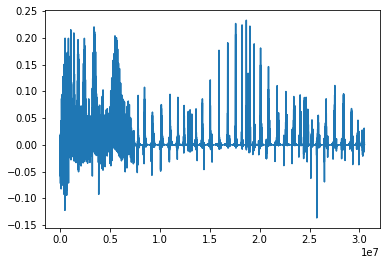

In [247]:

for diff in central_diffs:
    py.figure()
    py.plot(diff[0,:,0])
    py.show()

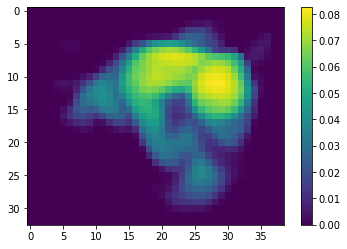

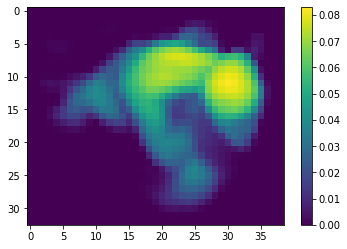

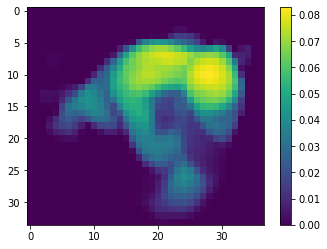

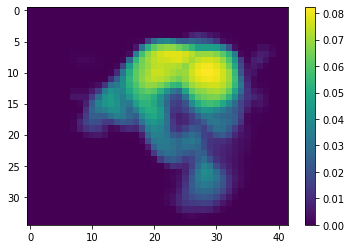

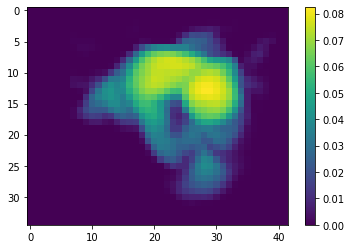

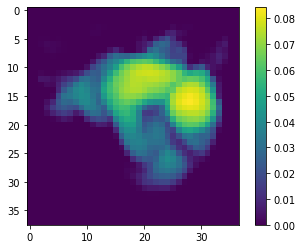

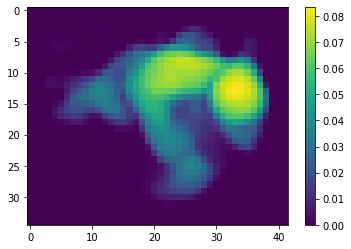

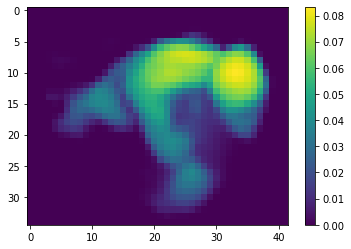

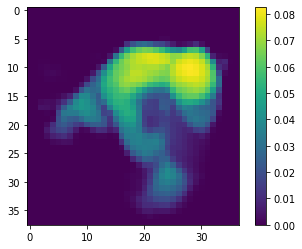

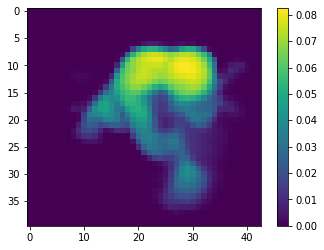

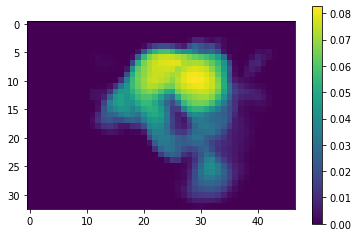

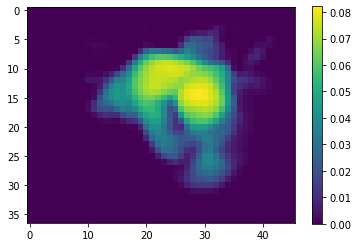

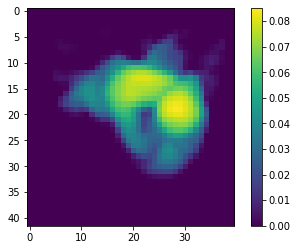

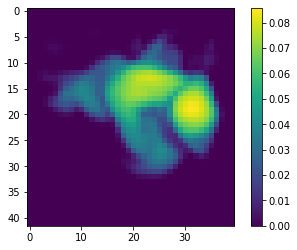

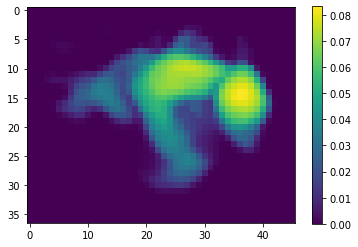

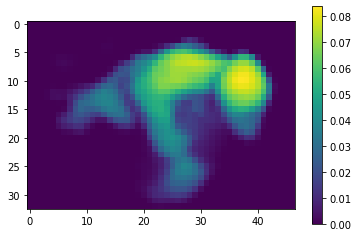

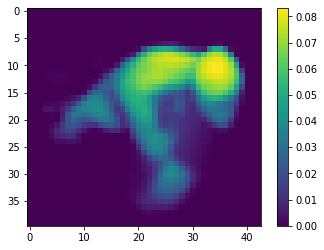

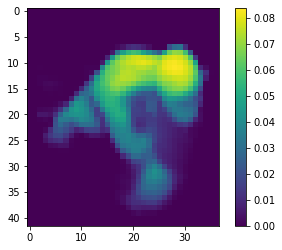

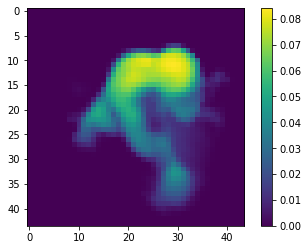

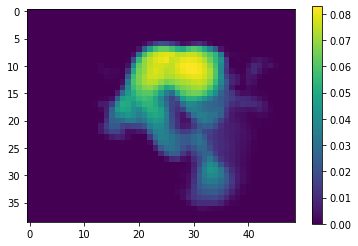

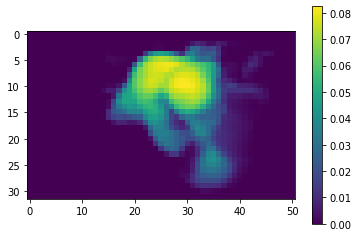

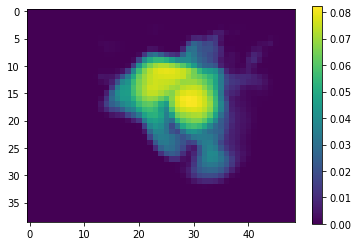

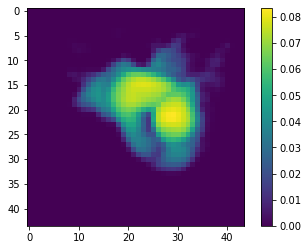

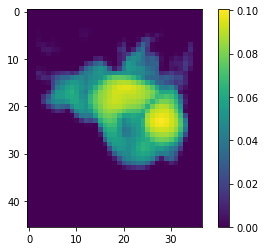

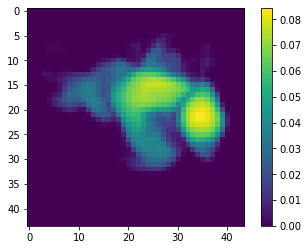

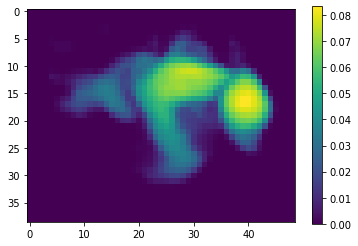

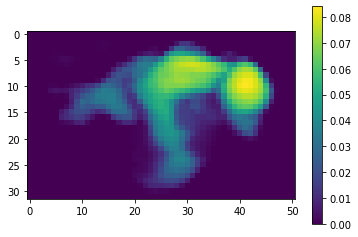

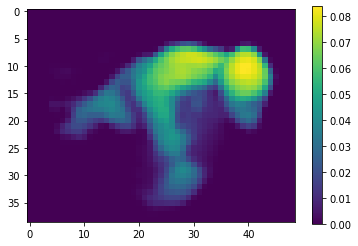

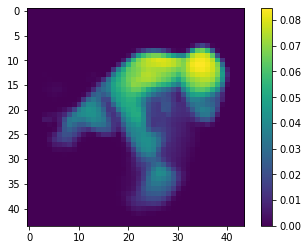

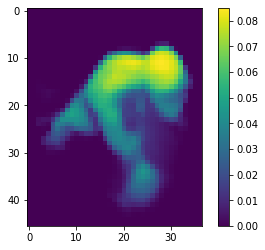

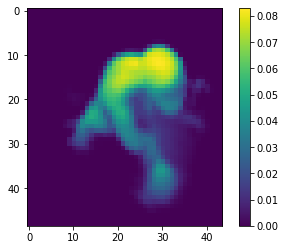

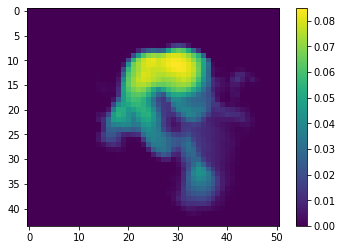

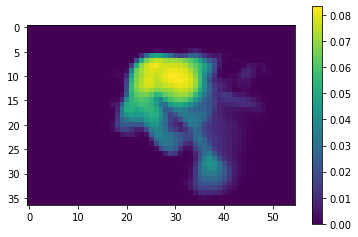

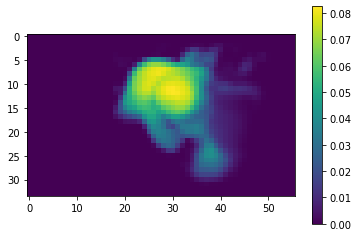

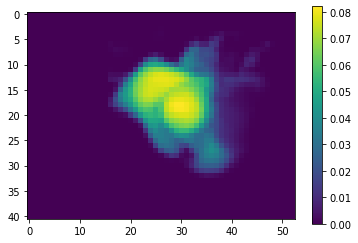

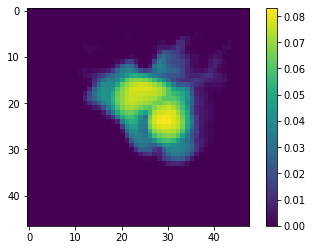

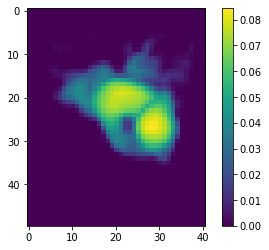

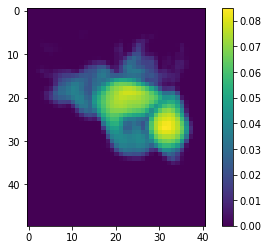

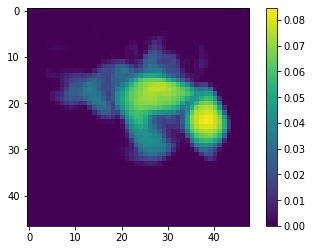

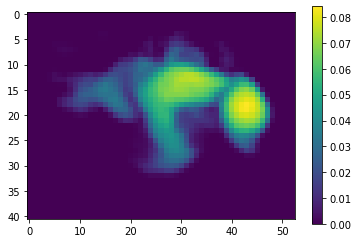

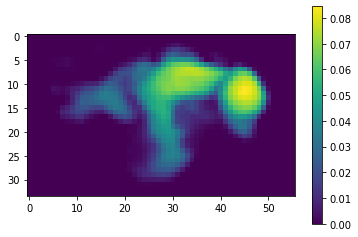

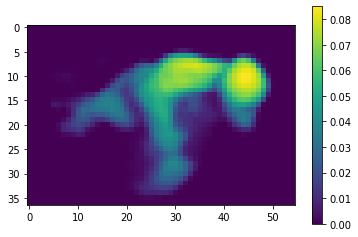

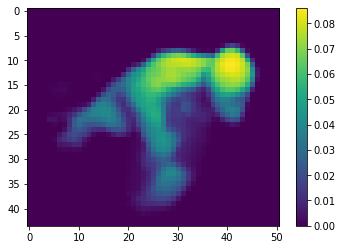

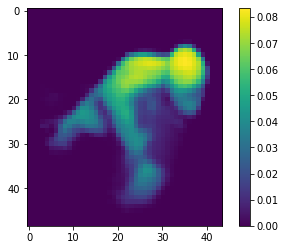

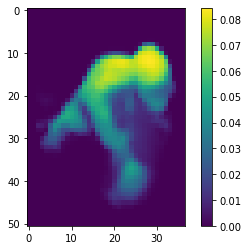

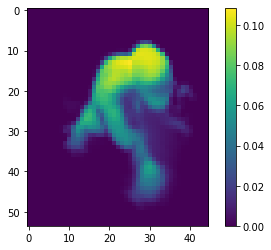

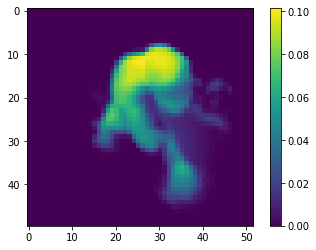

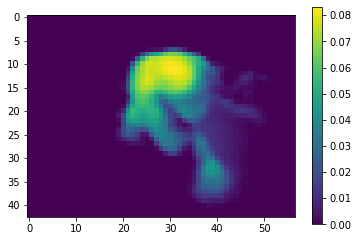

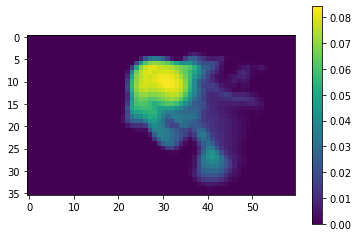

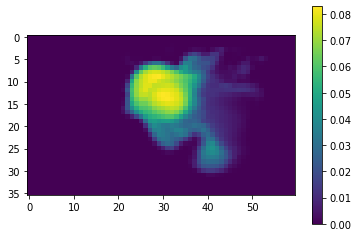

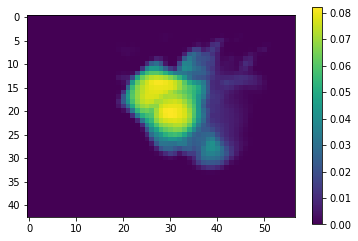

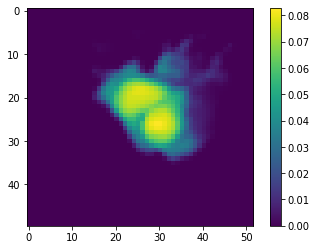

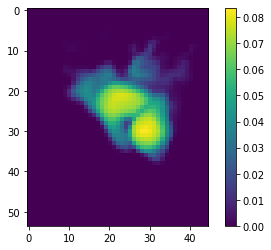

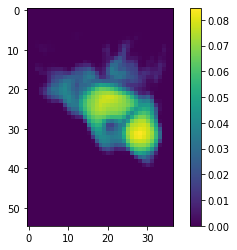

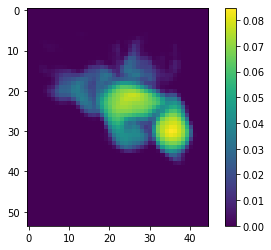

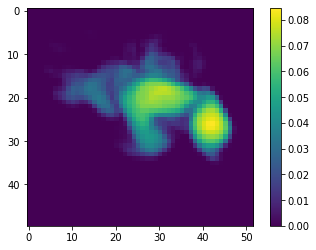

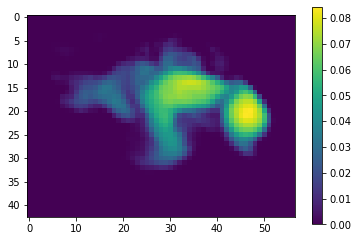

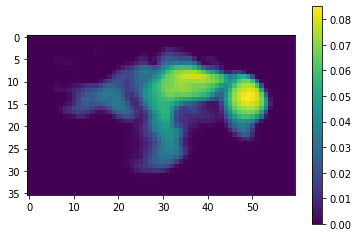

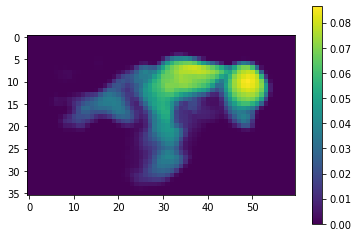

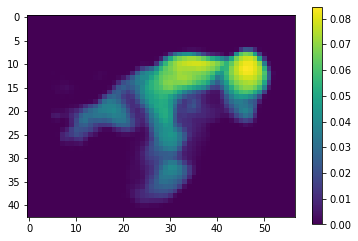

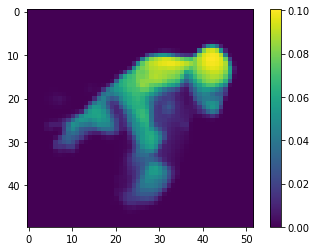

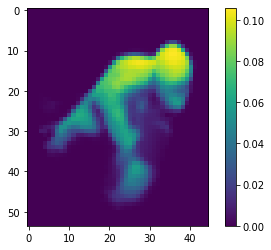

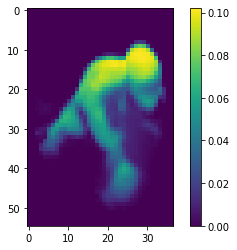

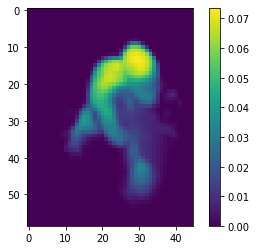

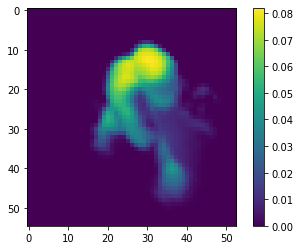

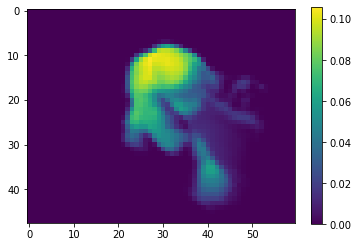

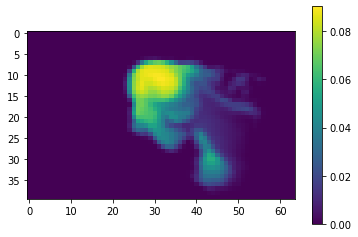

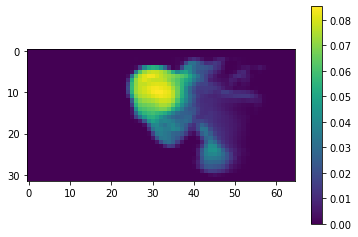

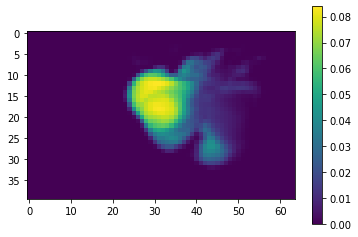

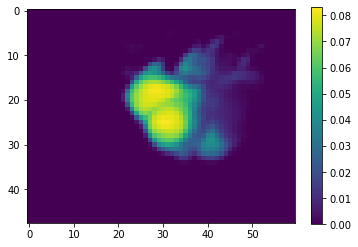

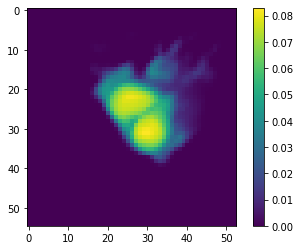

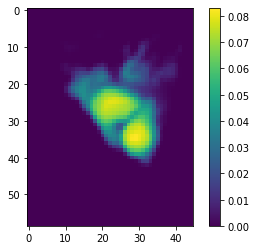

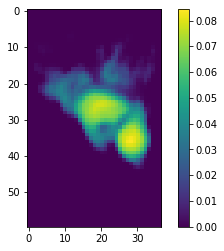

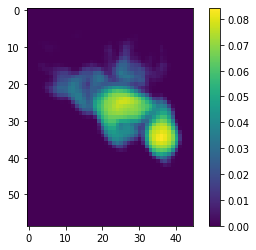

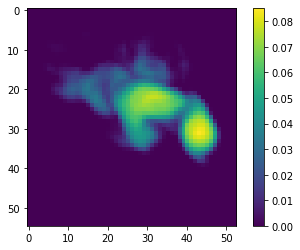

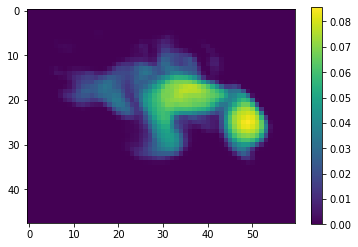

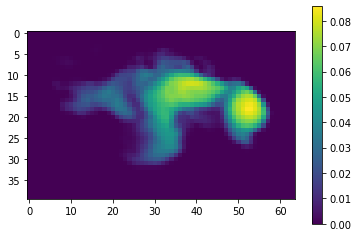

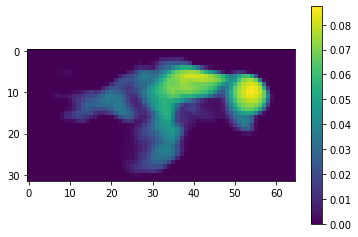

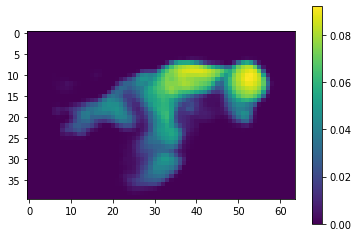

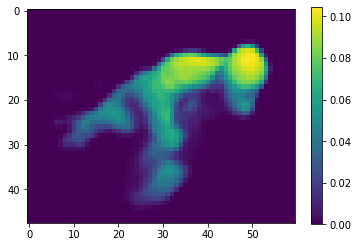

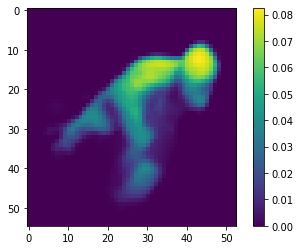

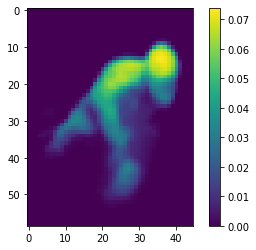

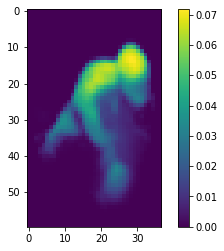

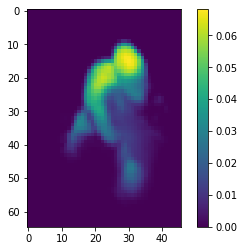

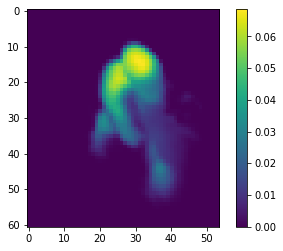

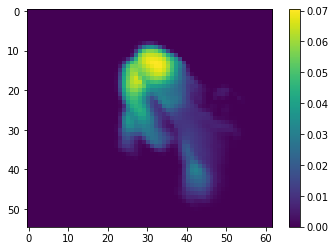

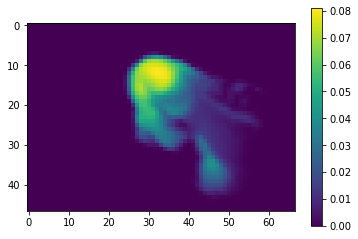

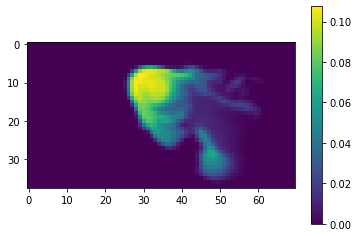

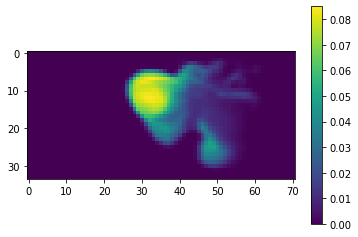

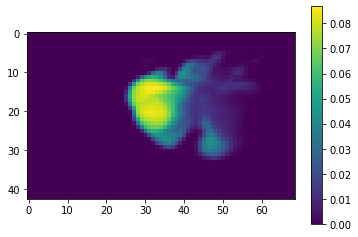

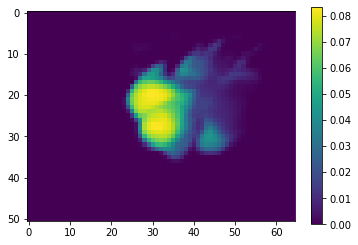

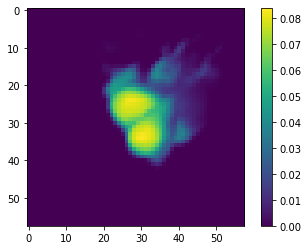

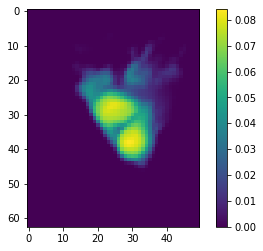

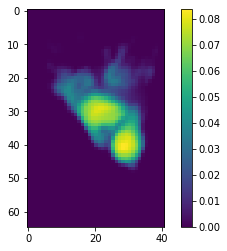

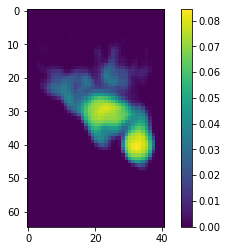

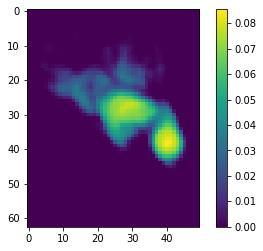

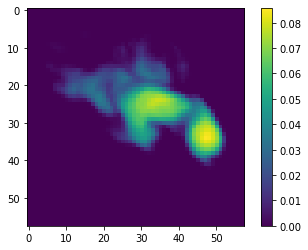

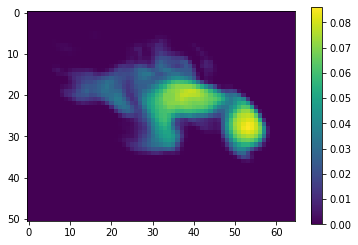

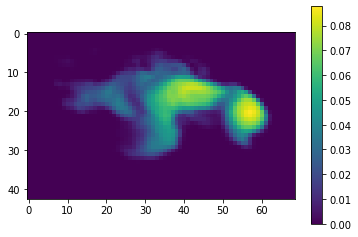

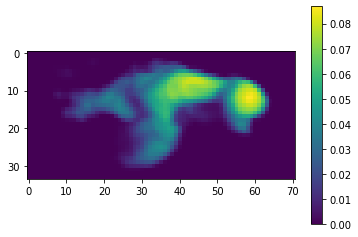

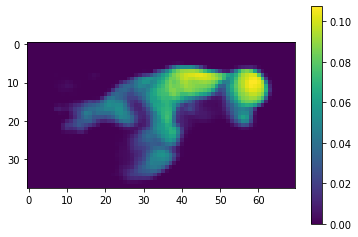

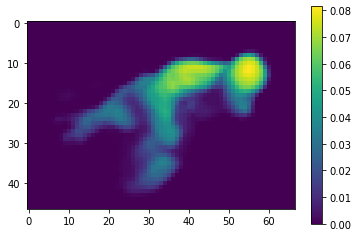

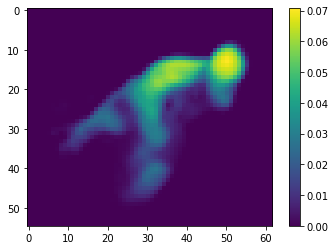

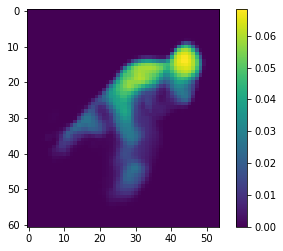

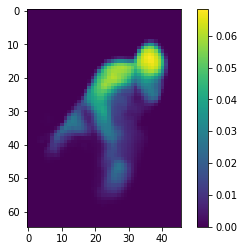

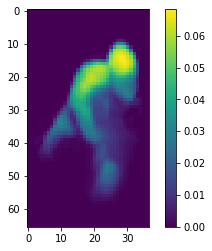

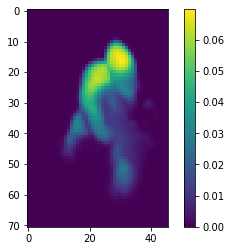

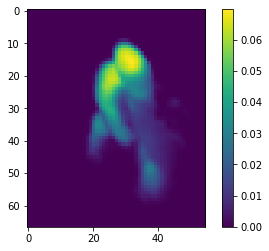

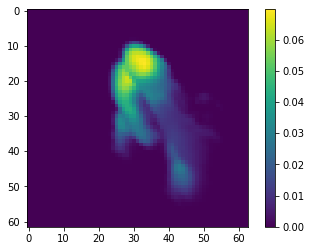

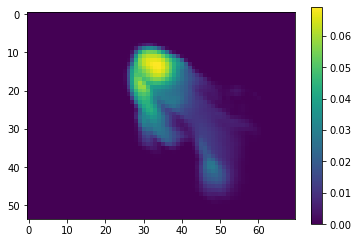

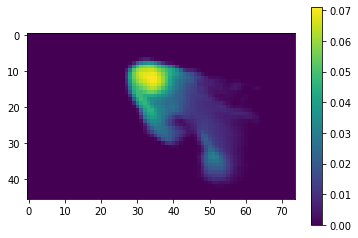

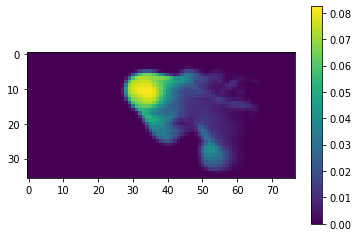

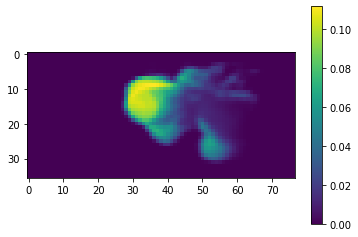

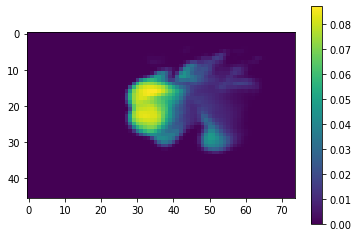

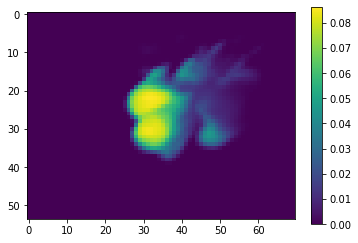

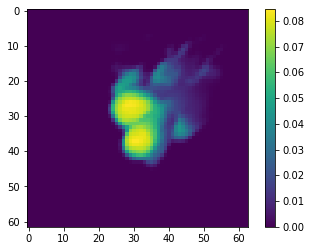

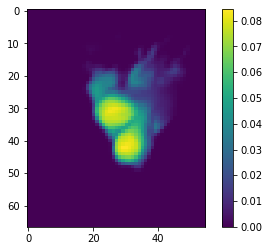

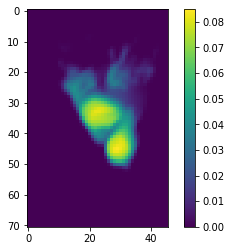

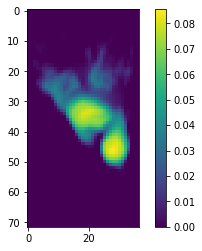

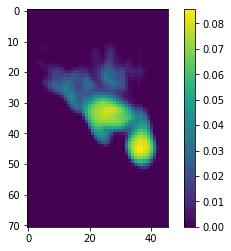

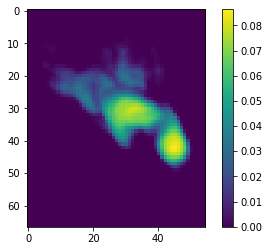

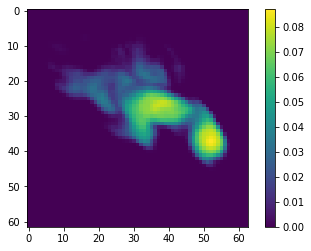

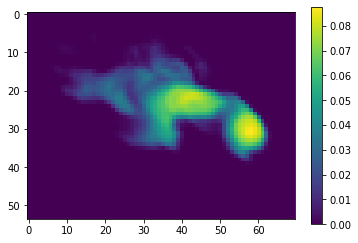

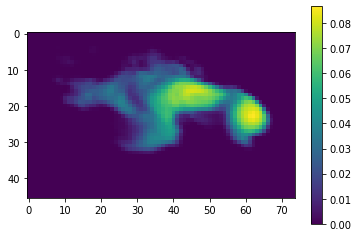

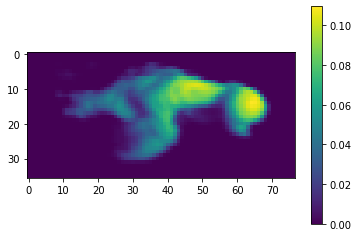

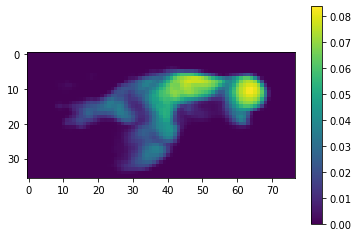

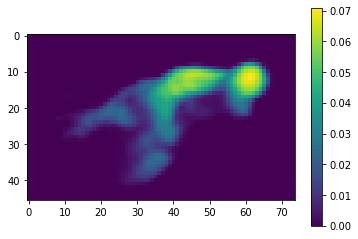

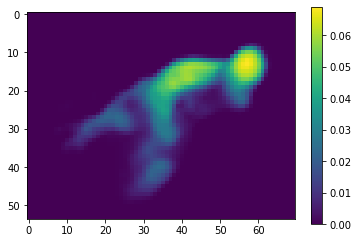

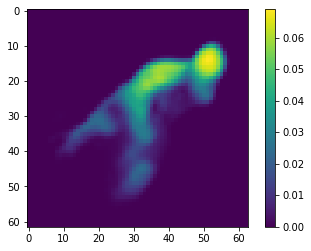

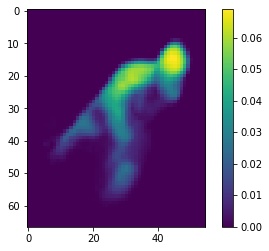

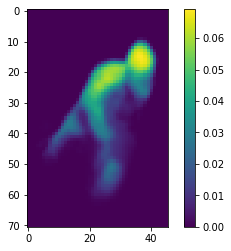

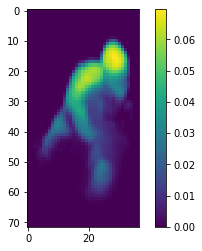

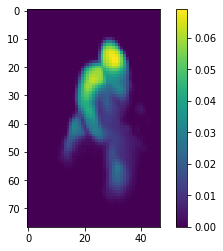

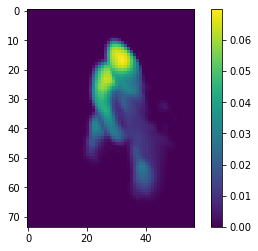

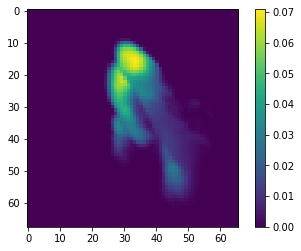

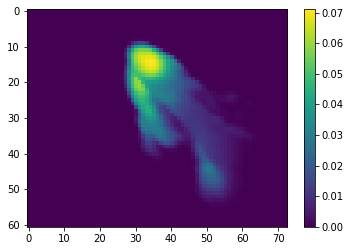

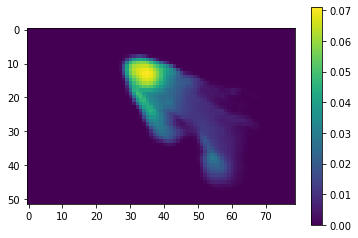

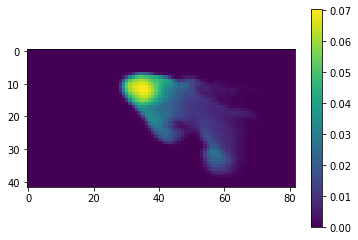

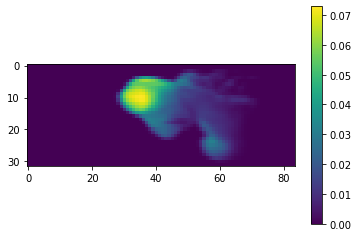

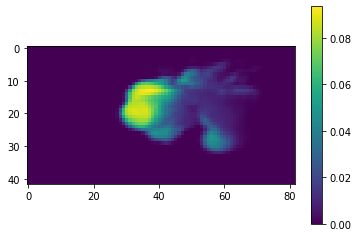

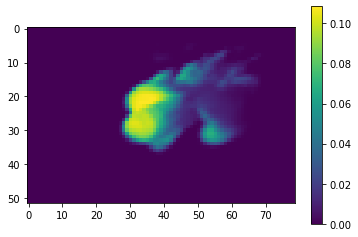

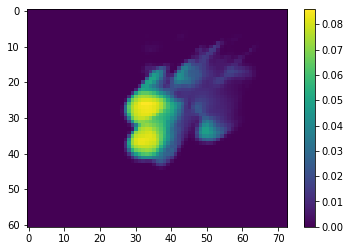

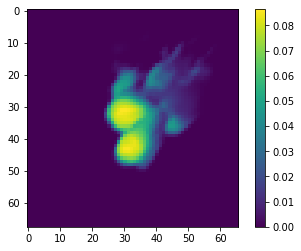

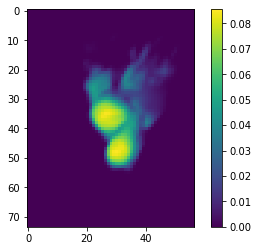

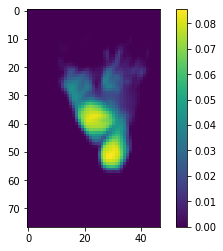

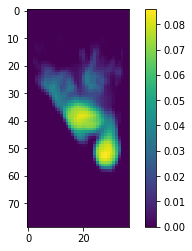

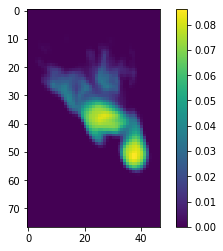

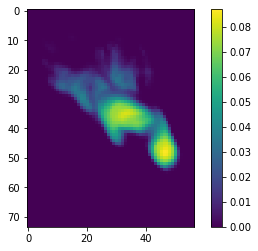

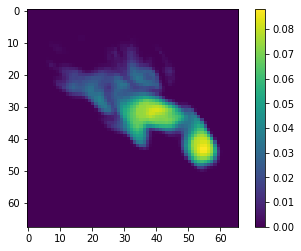

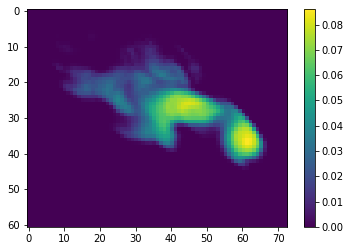

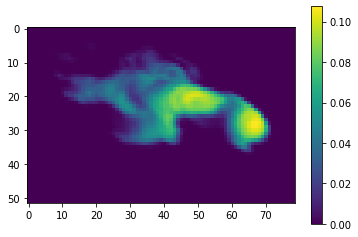

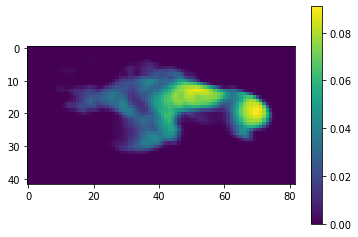

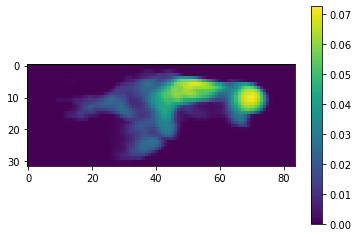

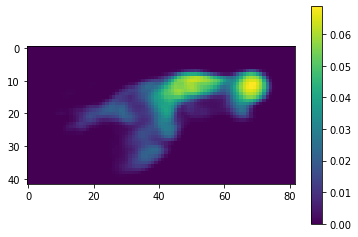

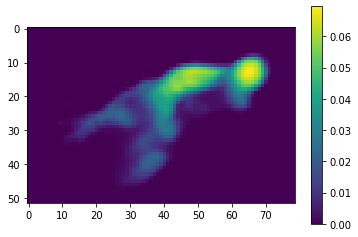

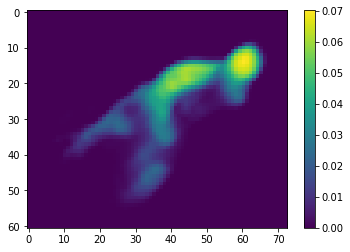

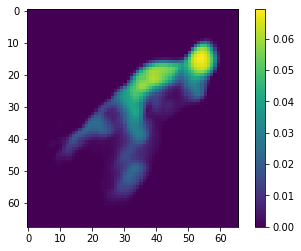

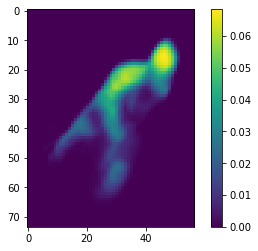

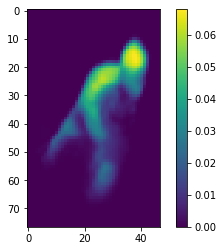

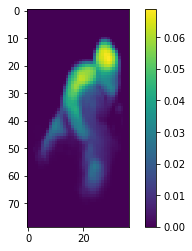

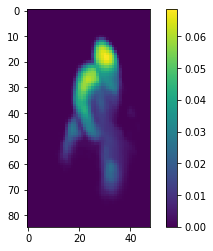

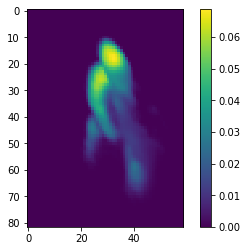

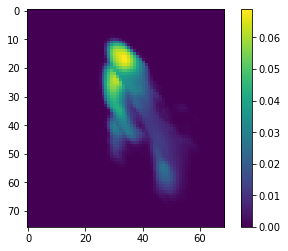

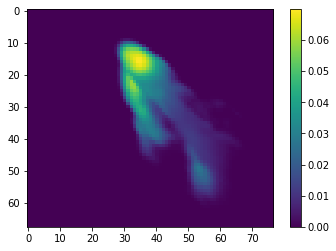

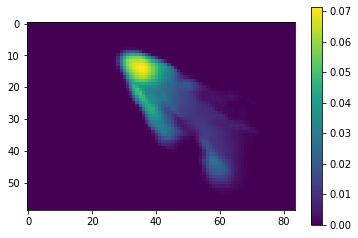

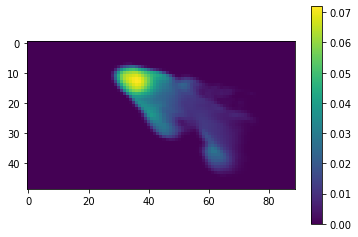

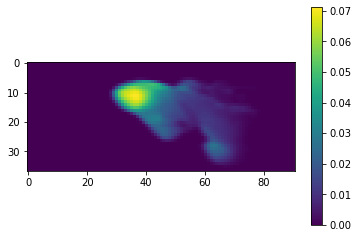

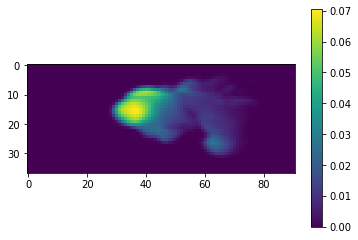

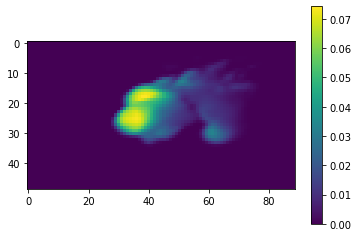

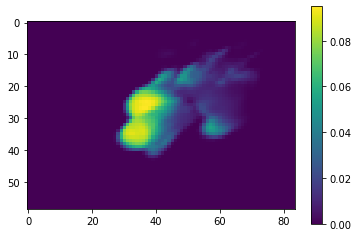

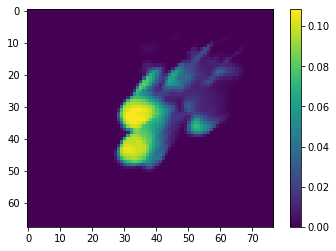

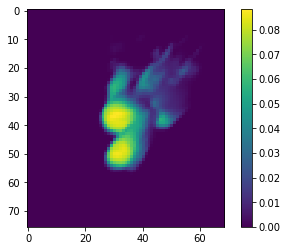

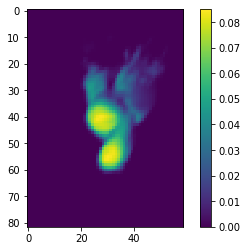

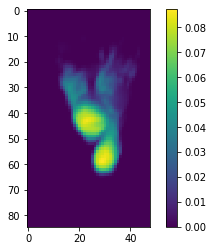

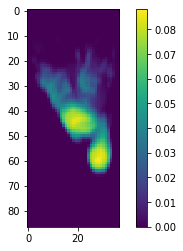

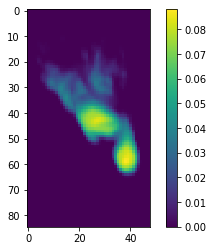

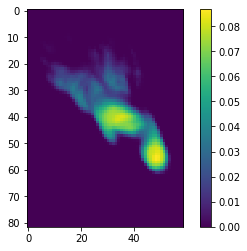

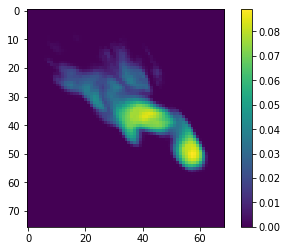

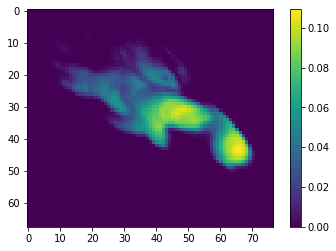

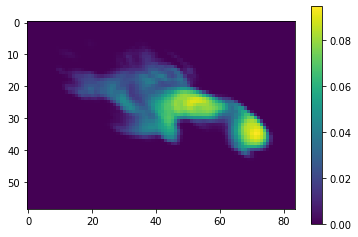

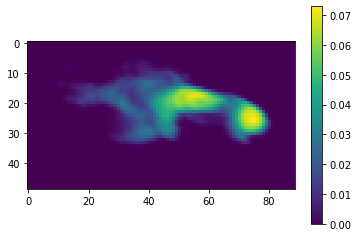

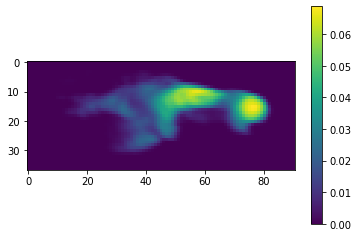

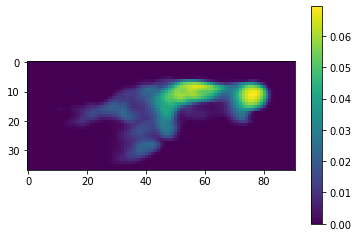

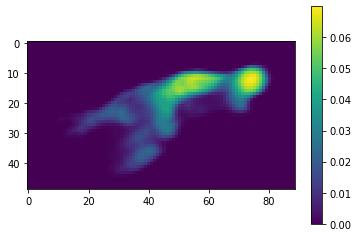

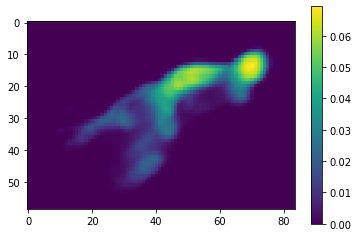

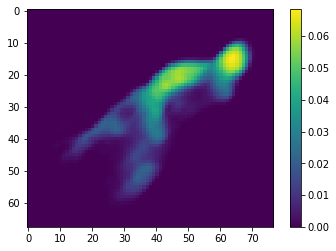

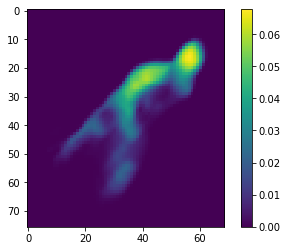

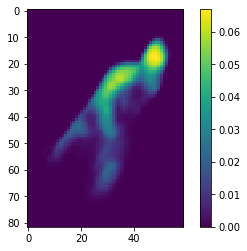

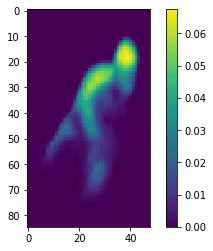

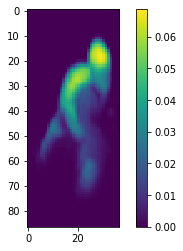

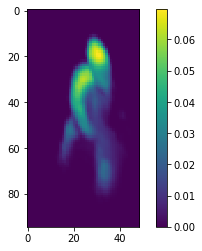

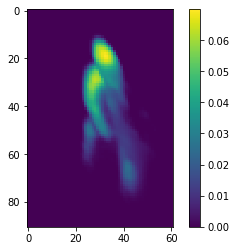

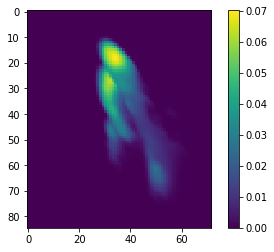

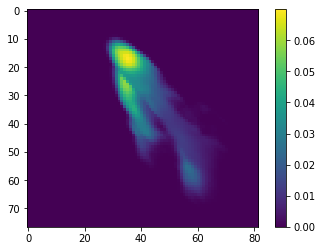

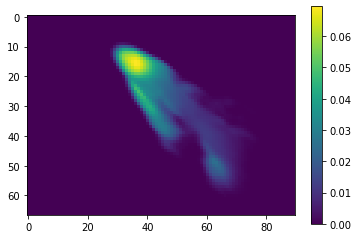

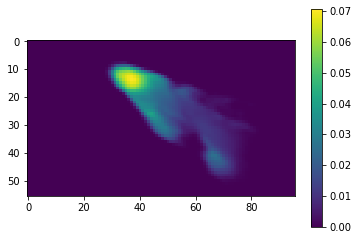

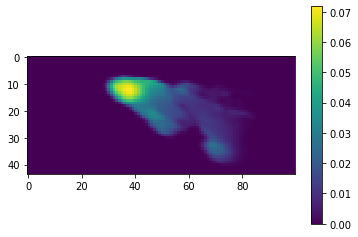

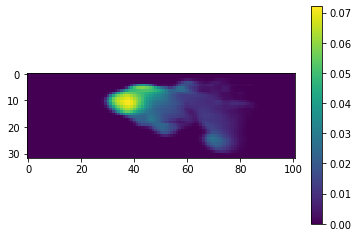

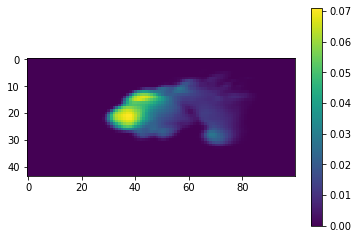

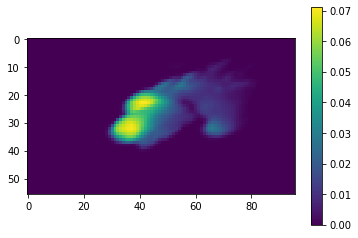

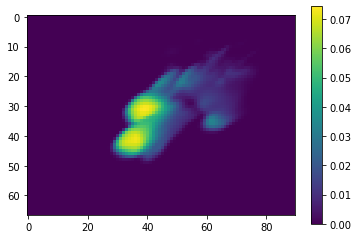

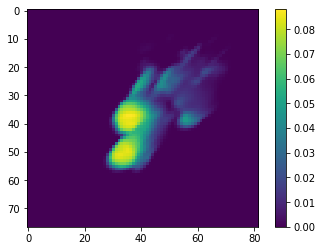

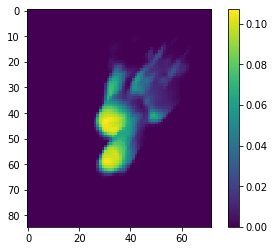

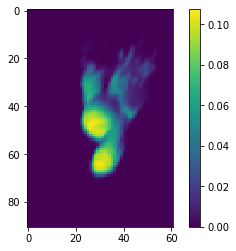

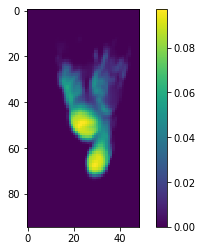

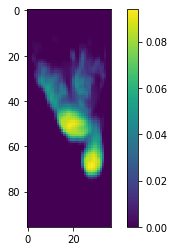

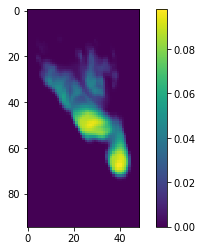

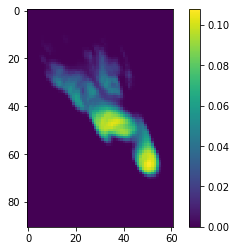

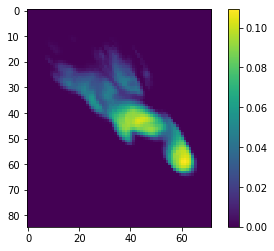

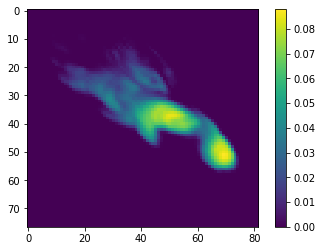

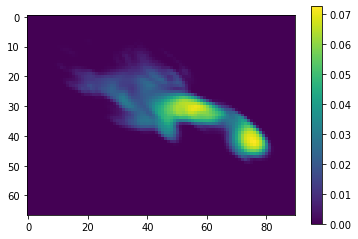

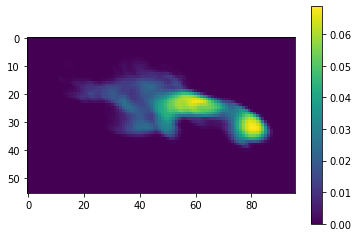

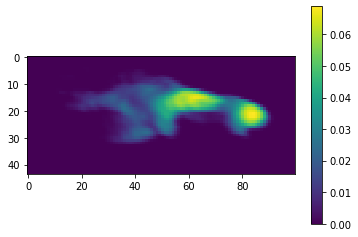

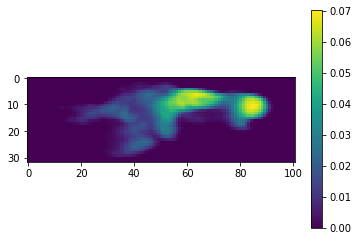

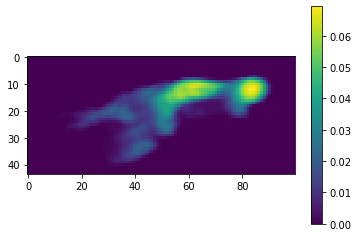

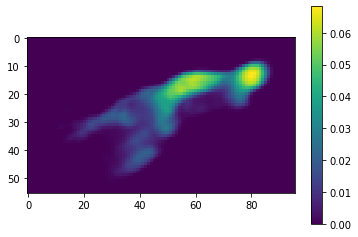

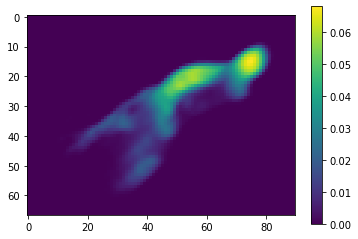

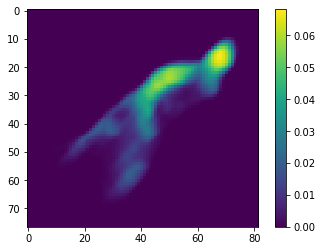

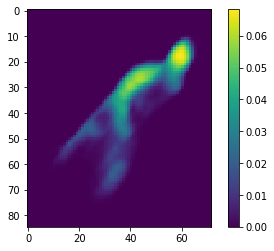

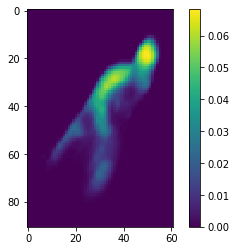

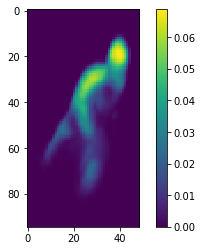

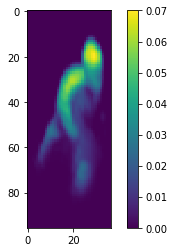

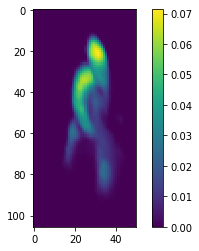

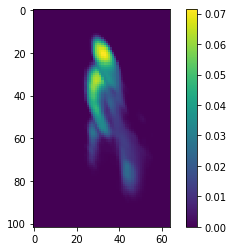

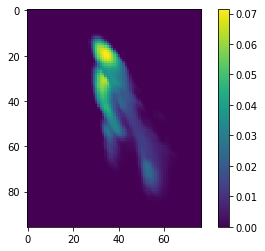

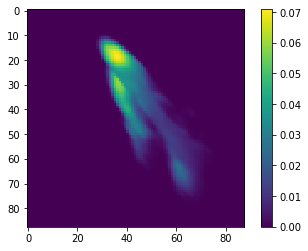

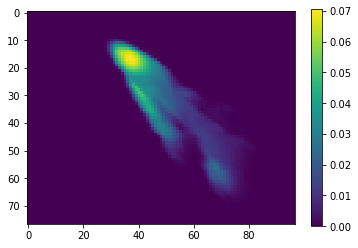

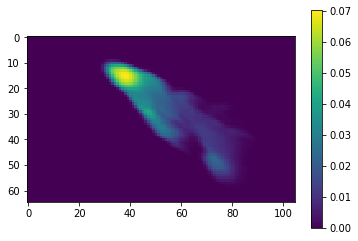

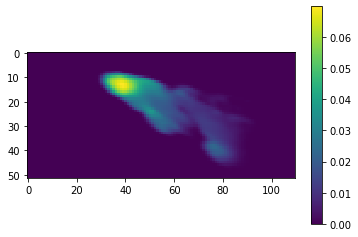

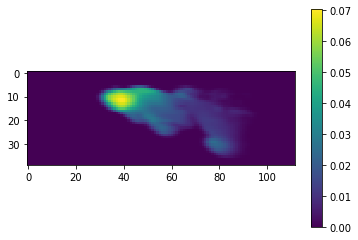

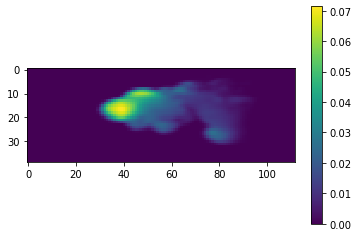

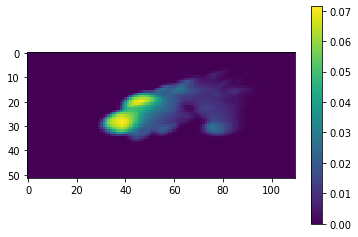

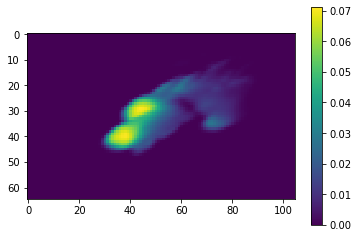

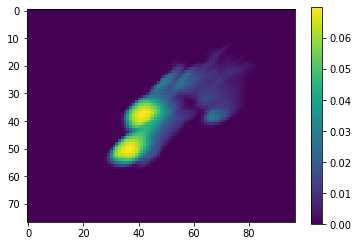

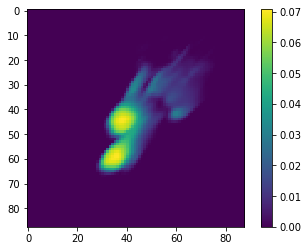

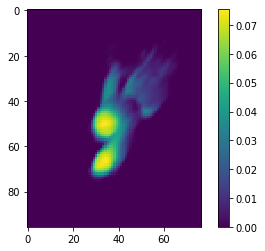

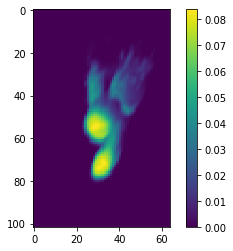

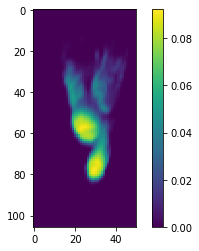

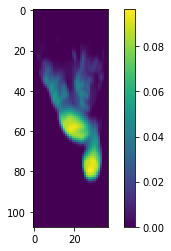

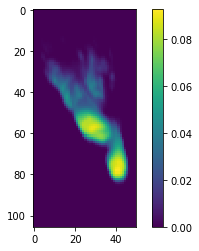

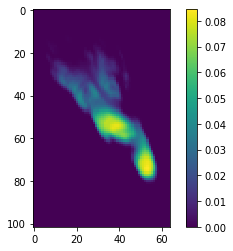

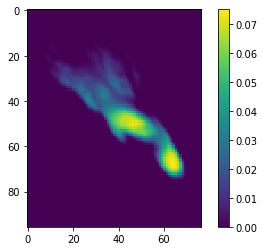

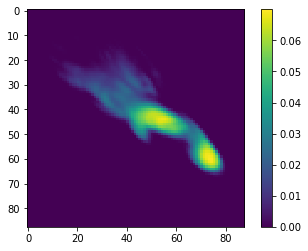

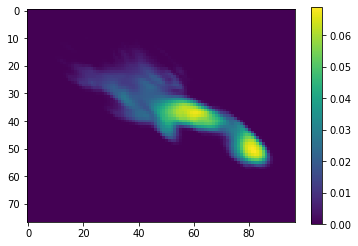

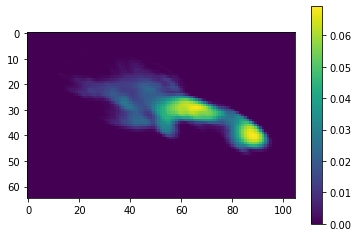

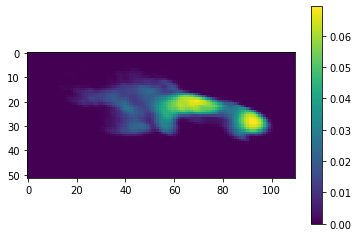

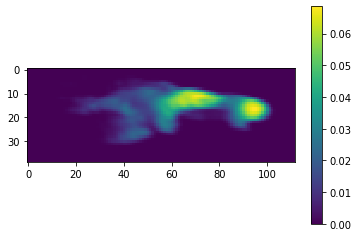

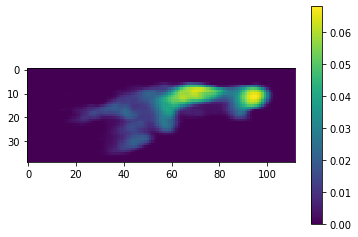

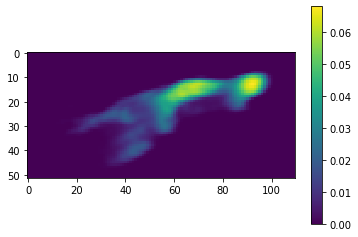

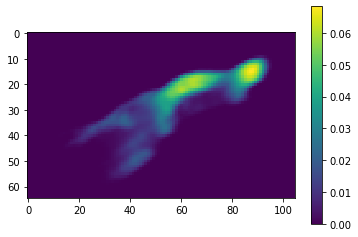

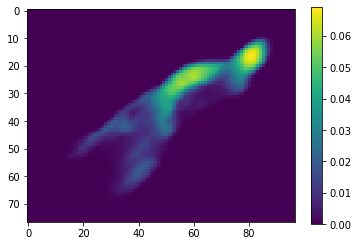

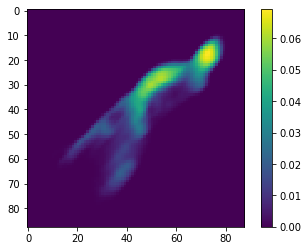

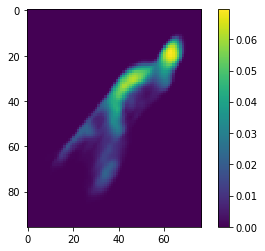

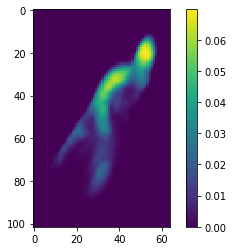

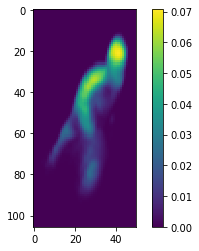

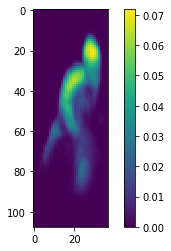

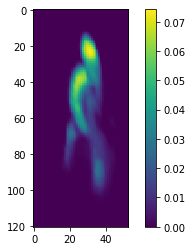

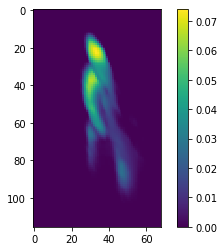

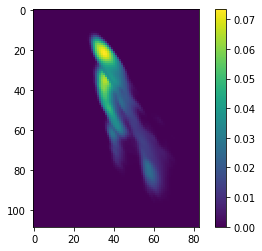

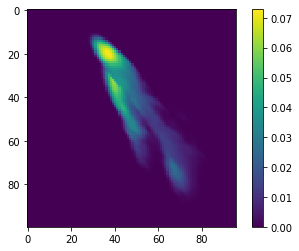

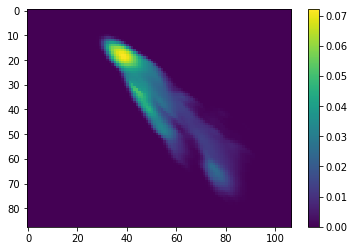

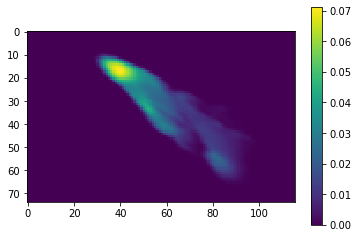

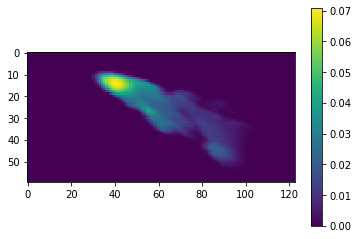

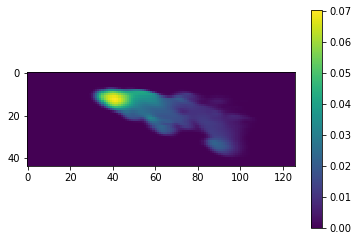

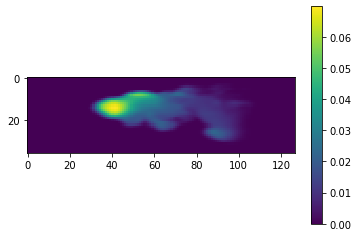

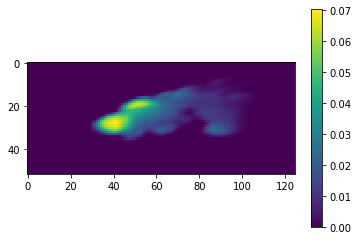

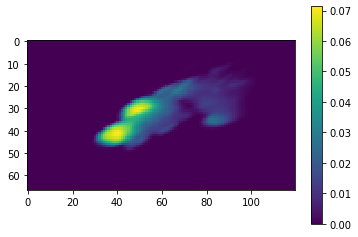

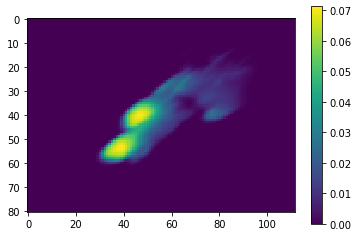

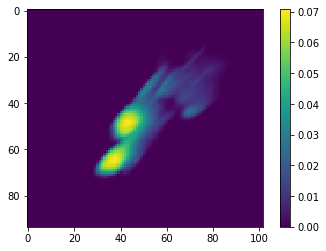

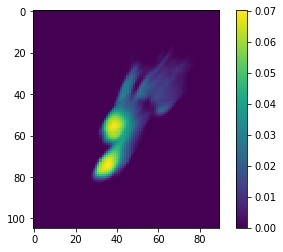

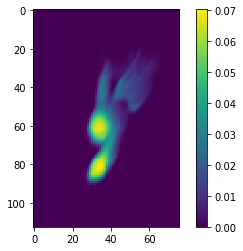

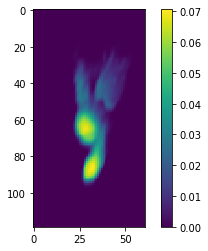

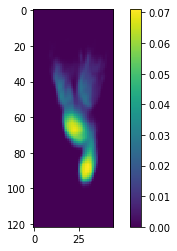

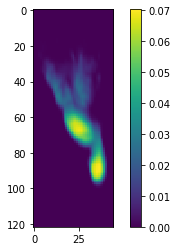

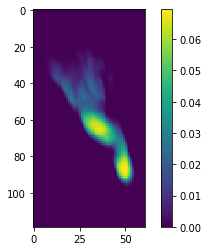

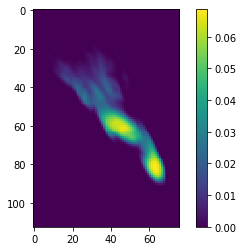

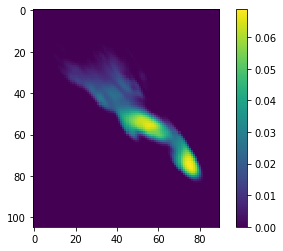

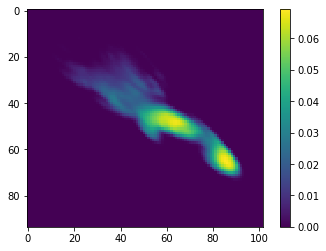

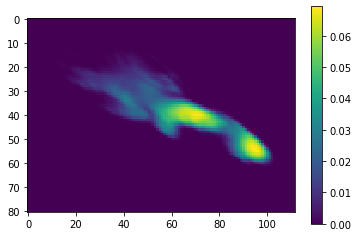

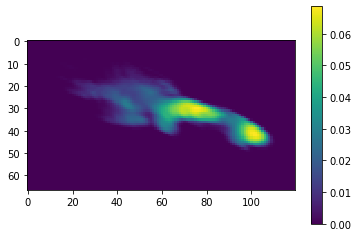

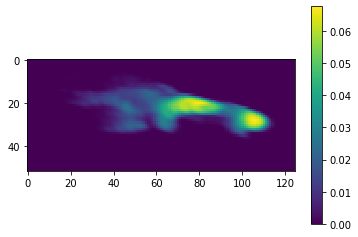

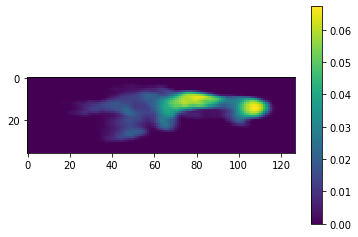

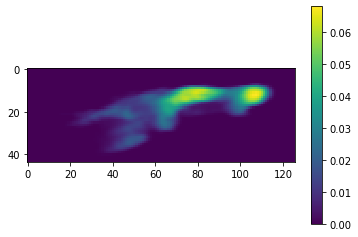

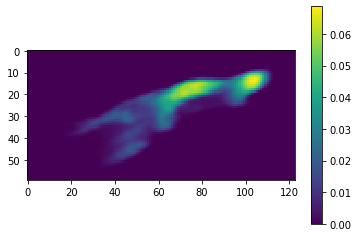

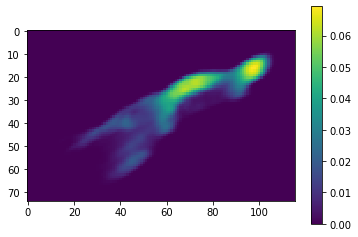

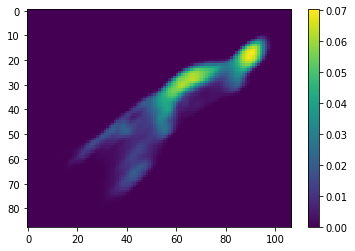

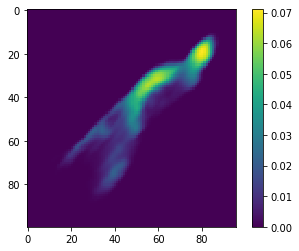

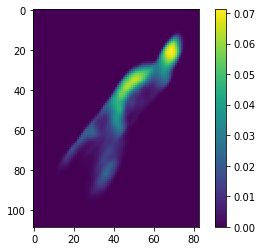

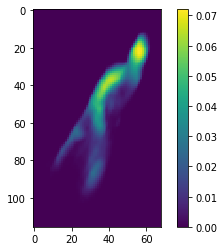

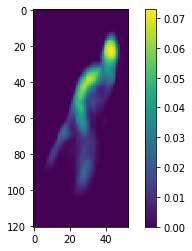

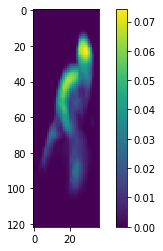

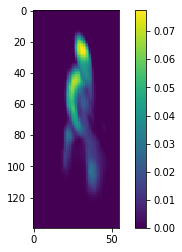

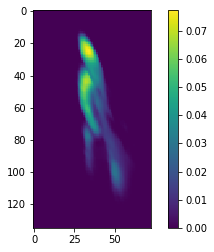

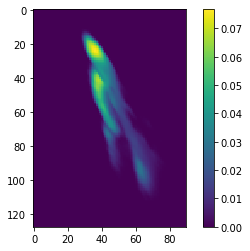

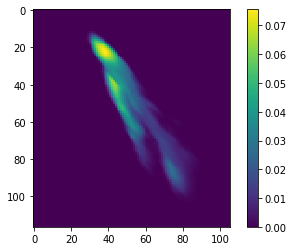

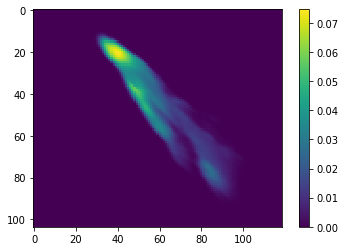

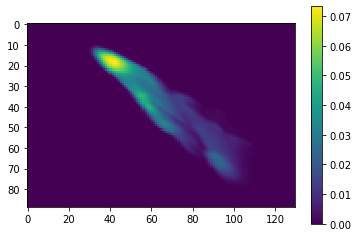

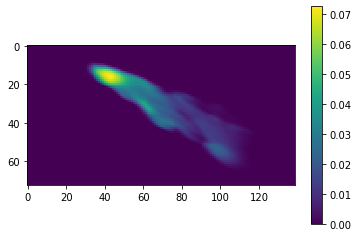

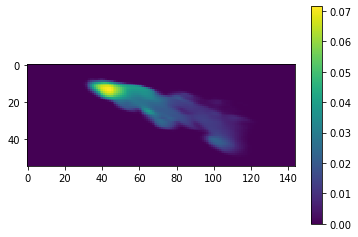

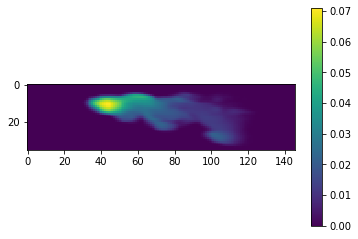

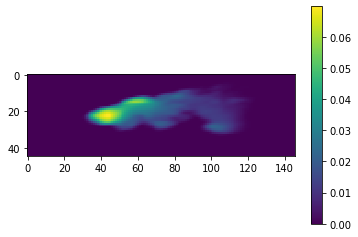

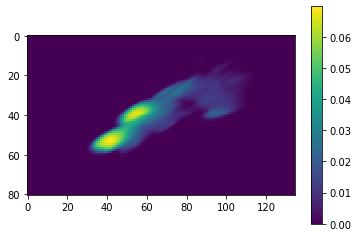

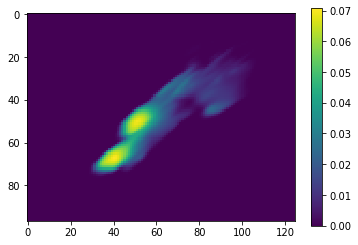

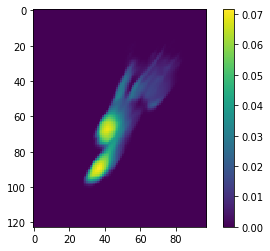

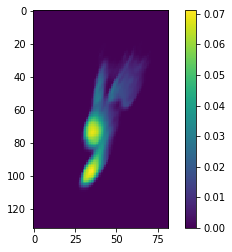

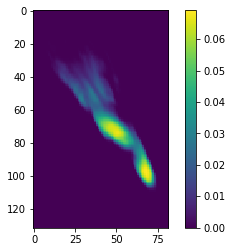

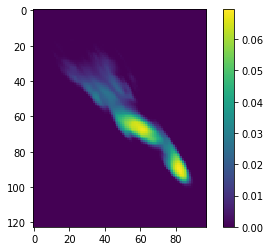

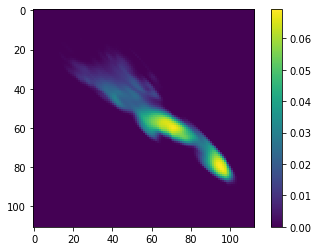

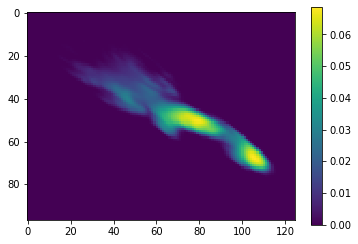

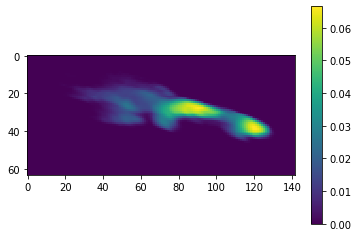

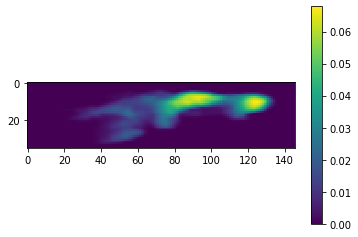

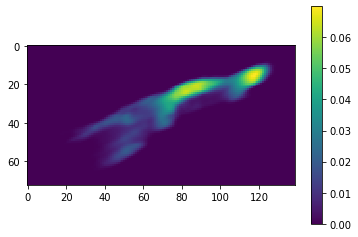

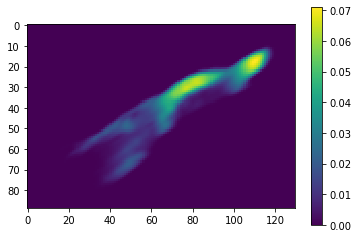

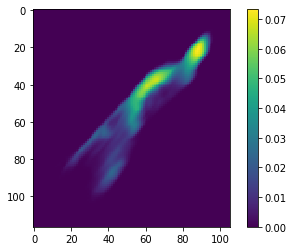

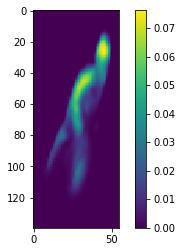

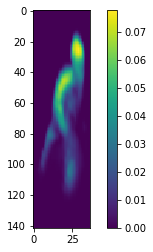

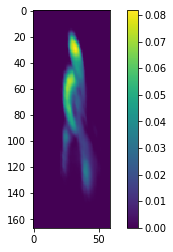

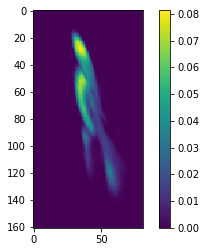

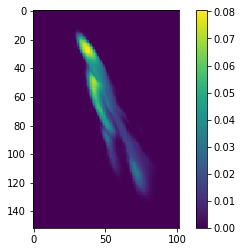

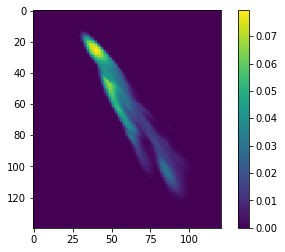

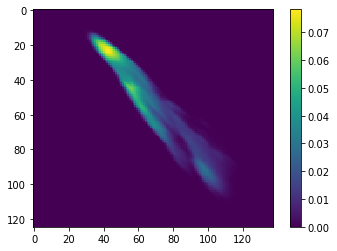

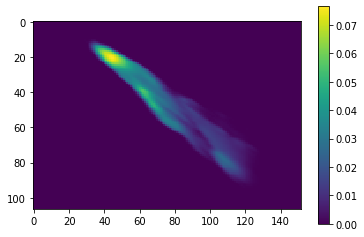

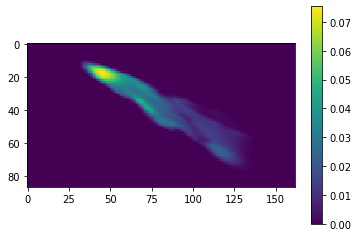

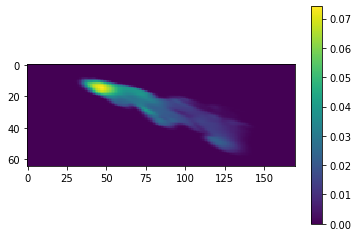

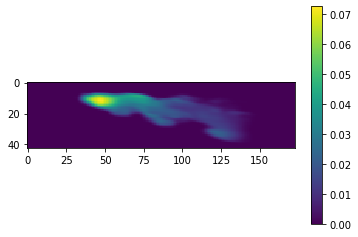

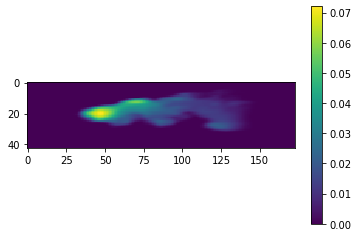

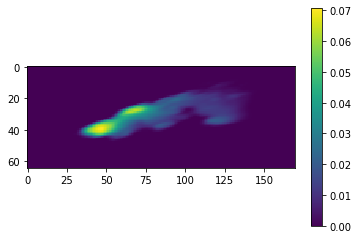

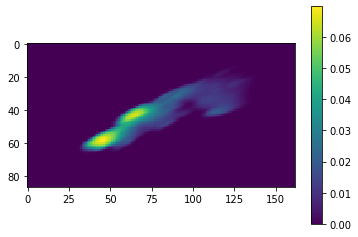

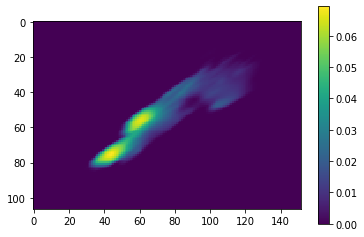

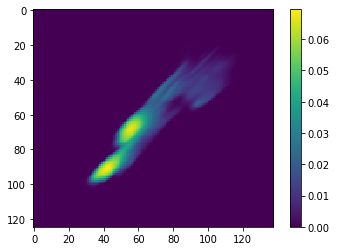

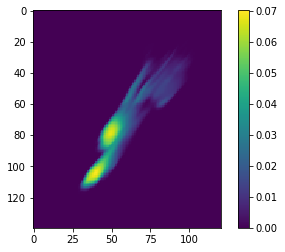

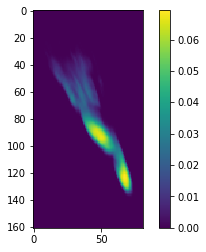

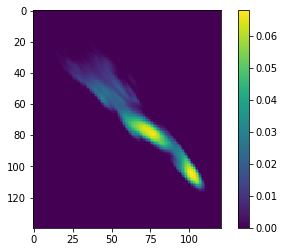

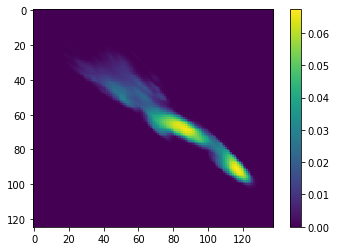

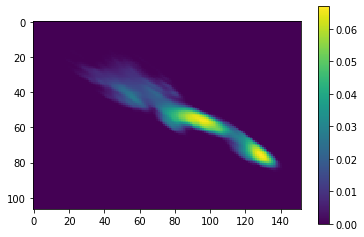

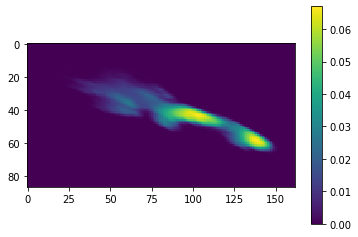

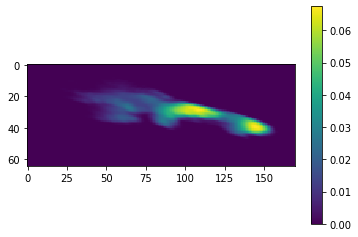

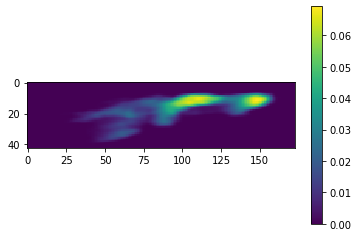

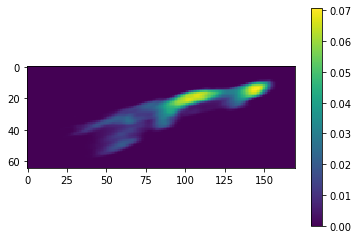

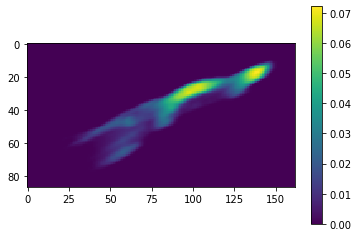

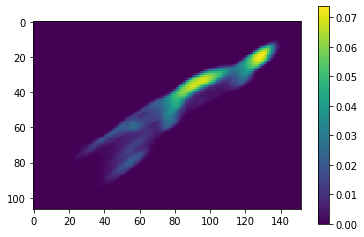

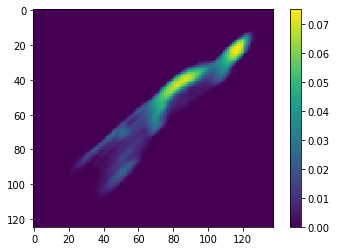

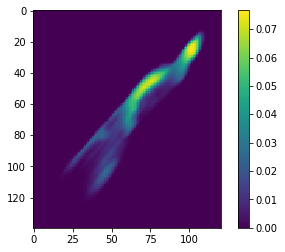

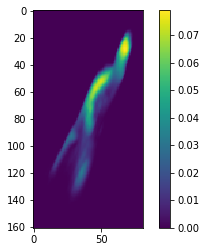

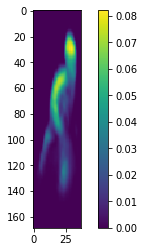

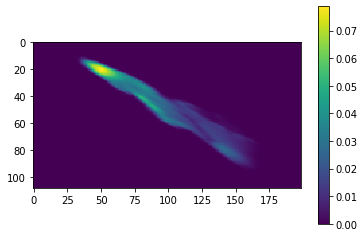

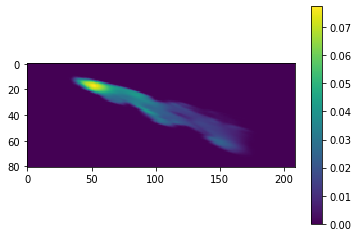

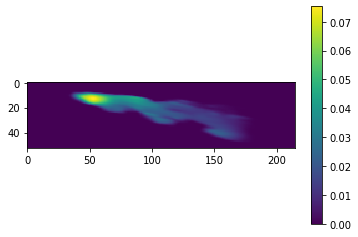

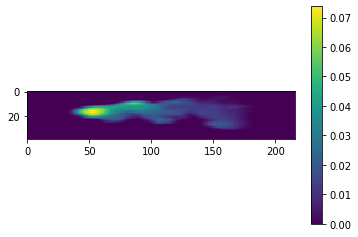

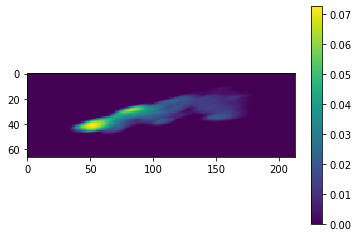

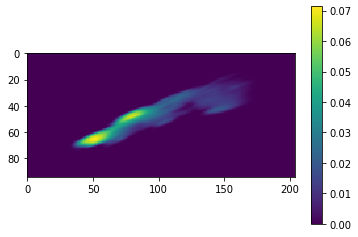

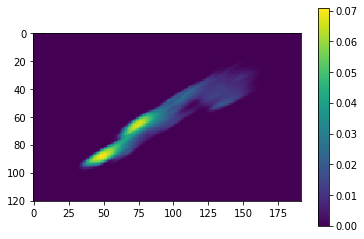

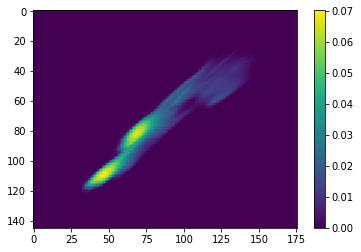

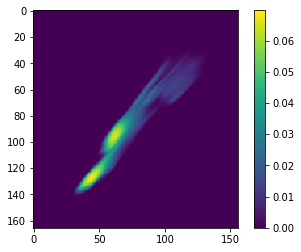

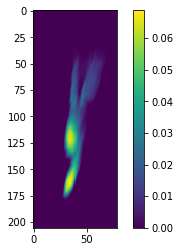

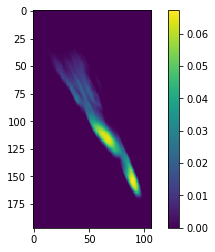

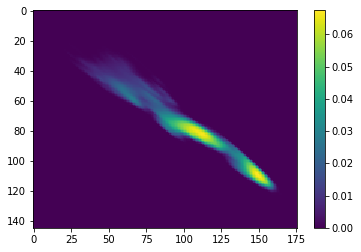

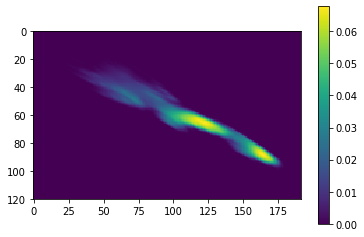

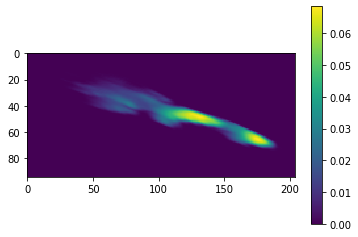

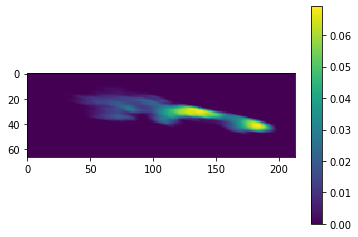

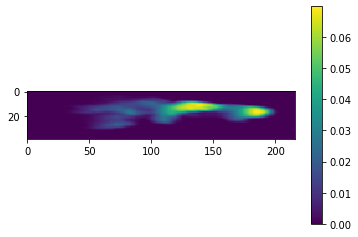

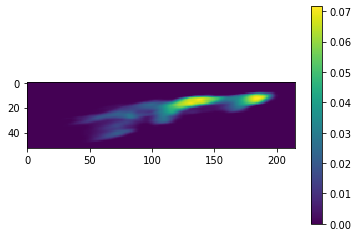

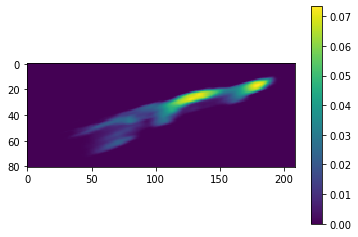

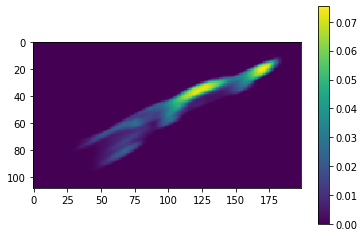

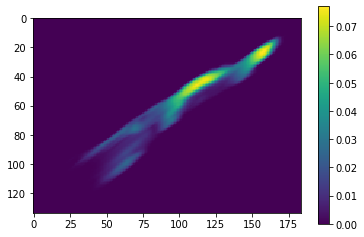

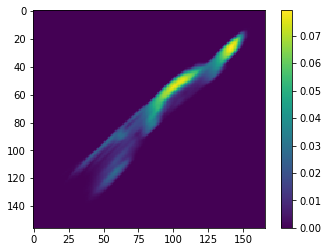

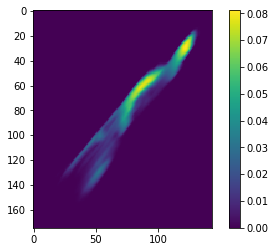

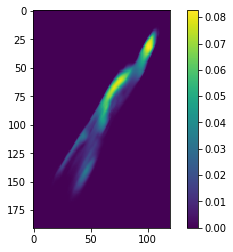

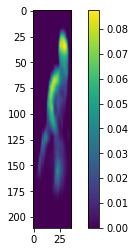

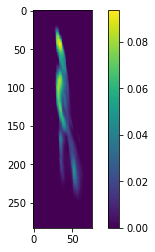

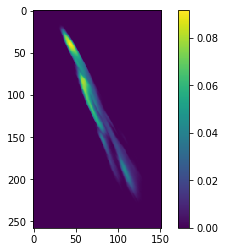

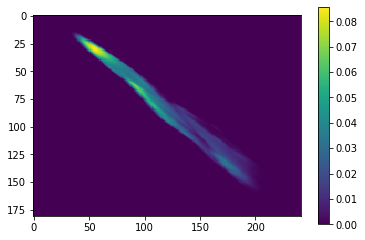

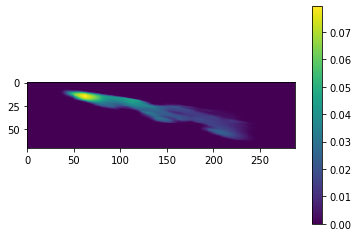

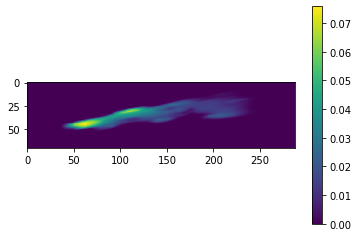

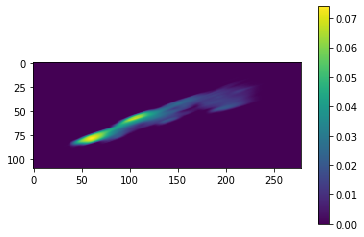

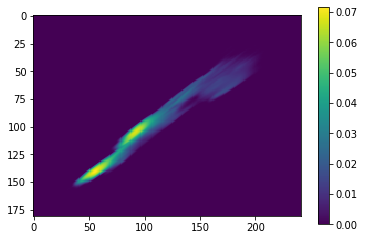

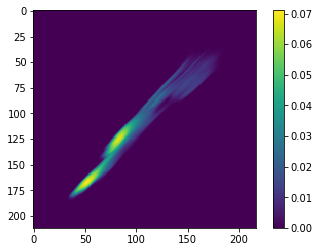

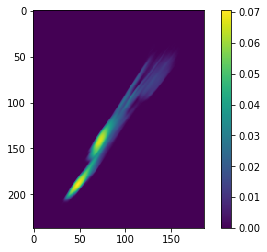

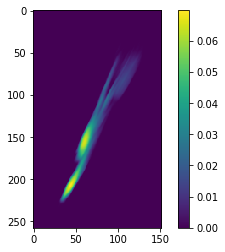

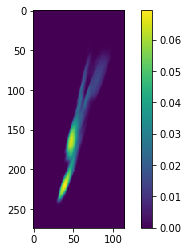

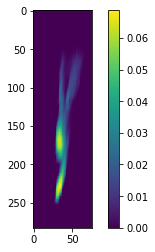

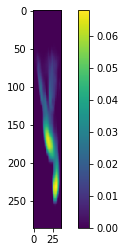

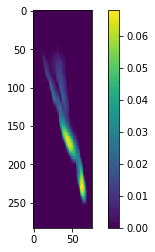

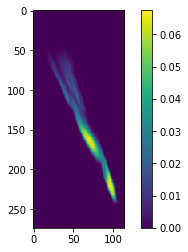

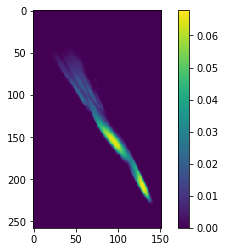

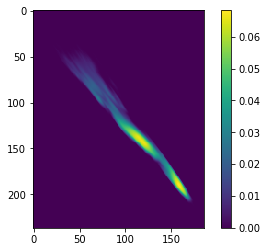

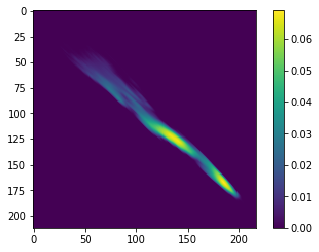

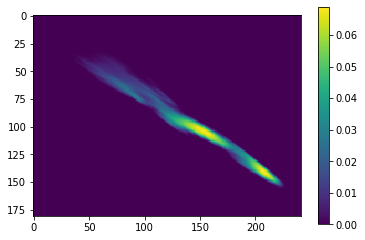

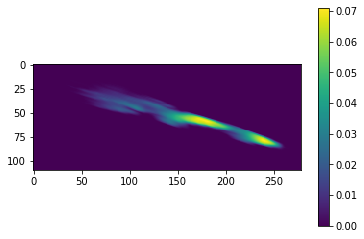

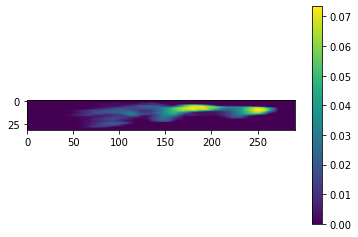

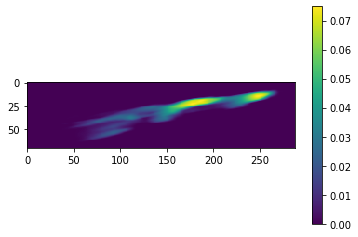

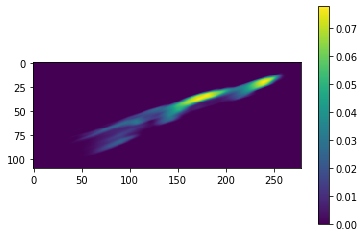

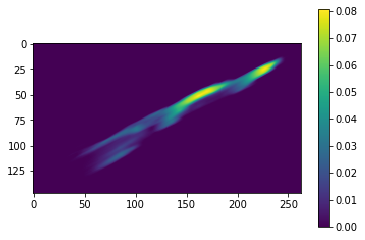

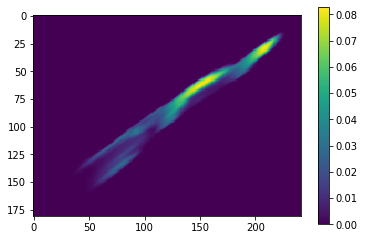

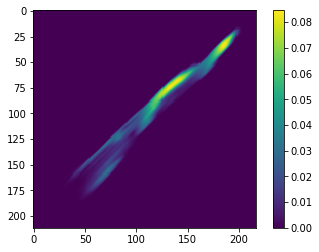

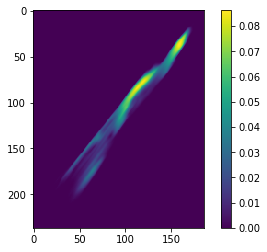

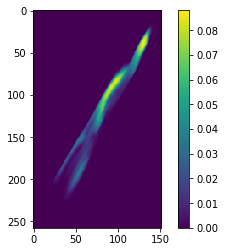

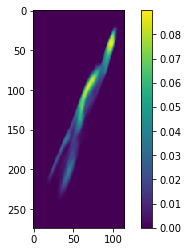

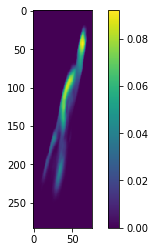

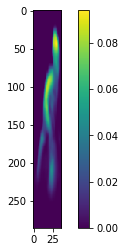

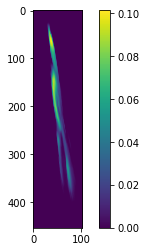

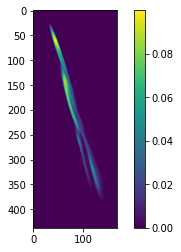

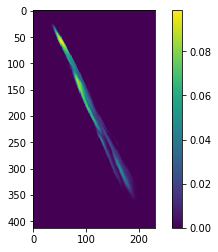

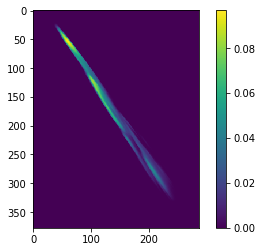

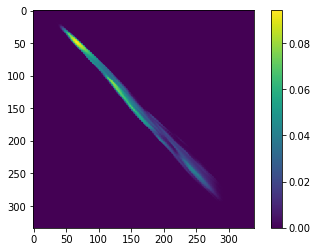

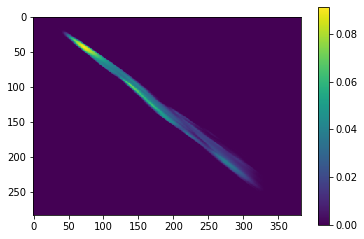

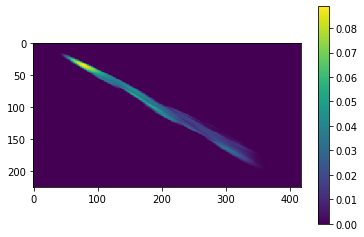

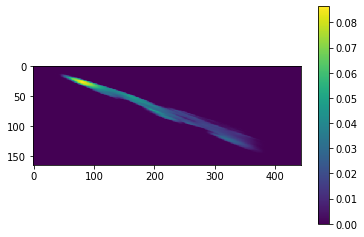

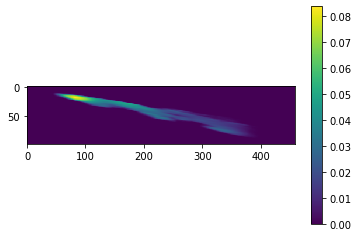

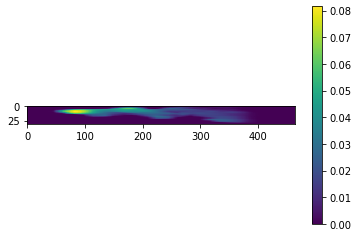

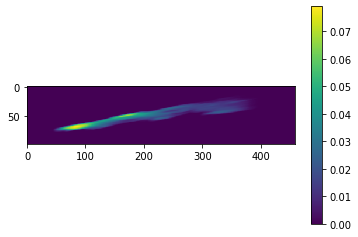

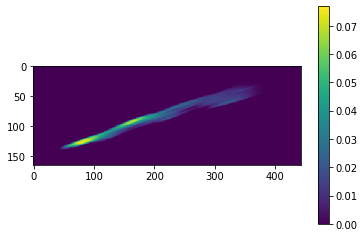

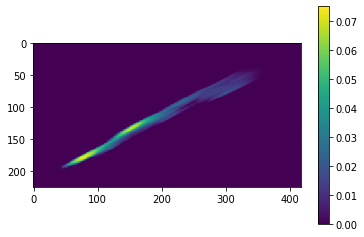

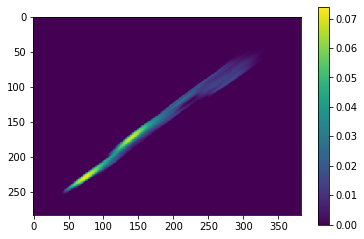

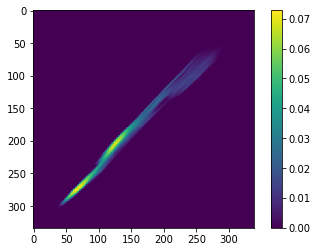

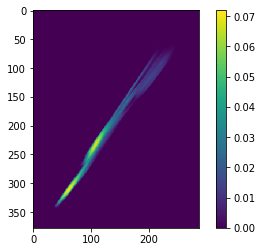

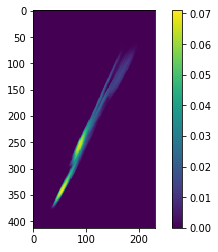

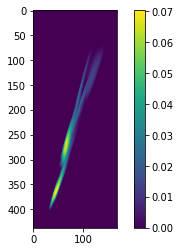

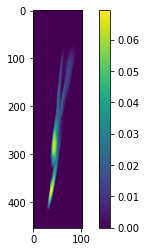

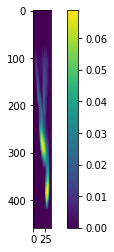

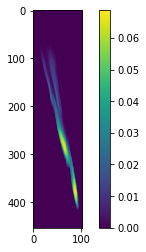

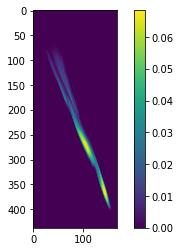

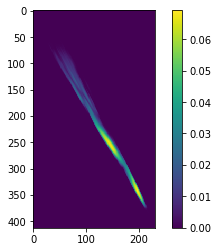

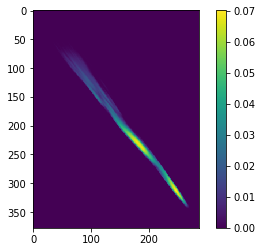

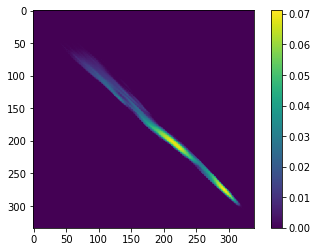

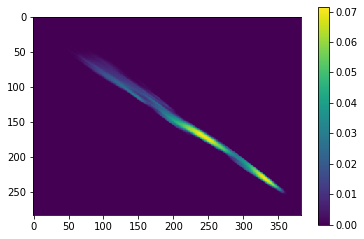

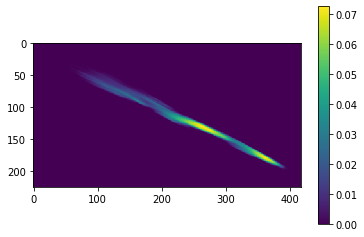

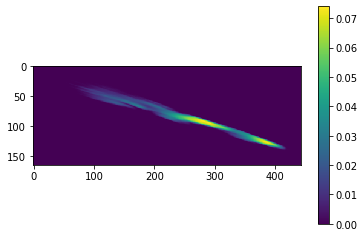

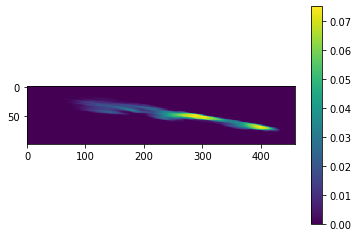

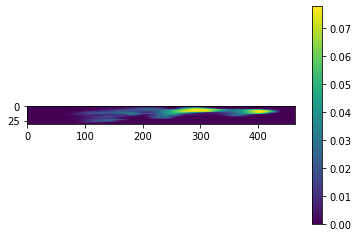

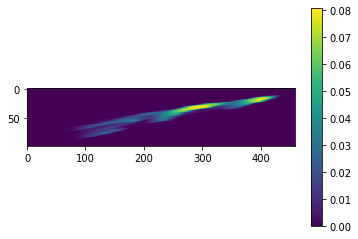

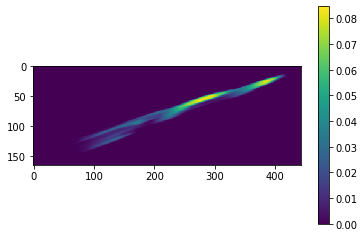

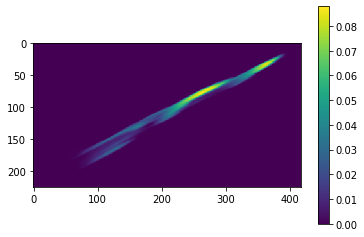

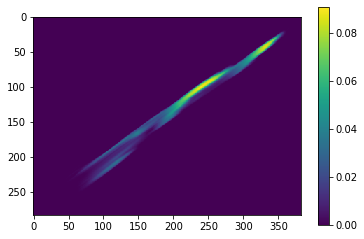

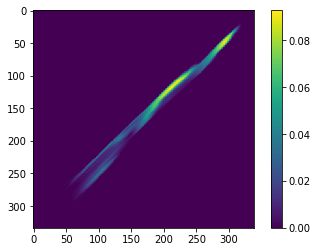

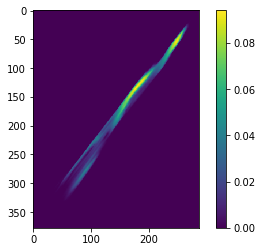

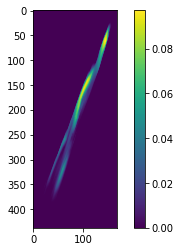

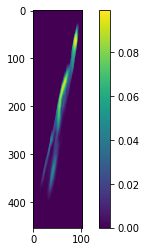

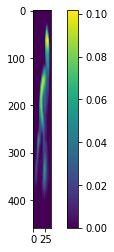

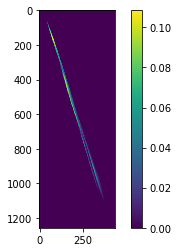

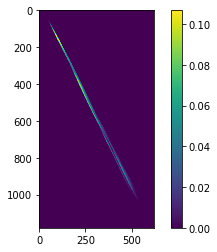

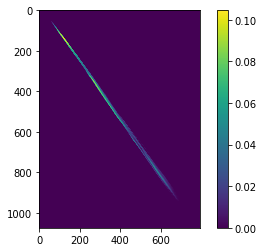

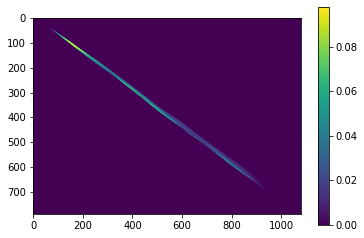

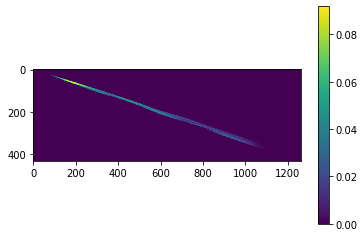

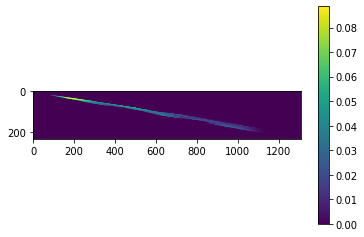

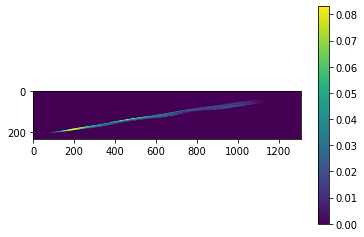

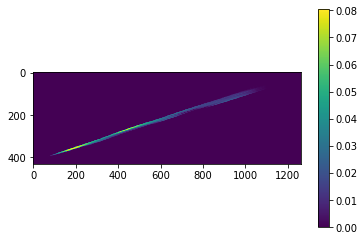

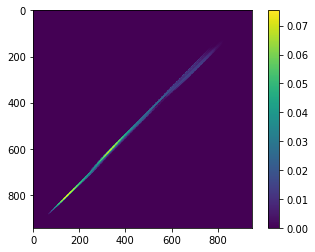

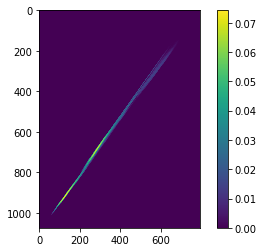

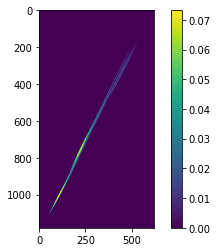

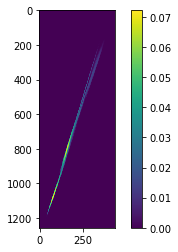

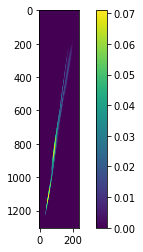

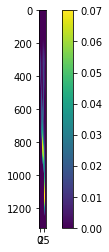

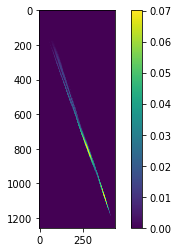

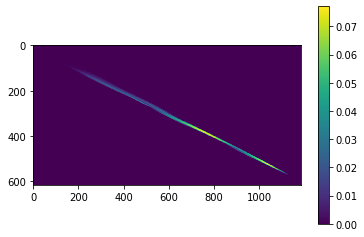

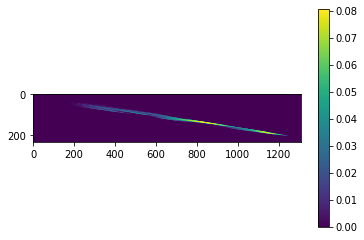

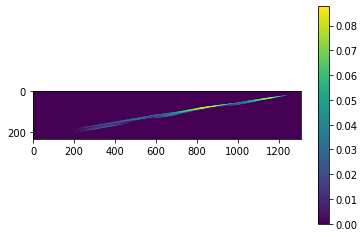

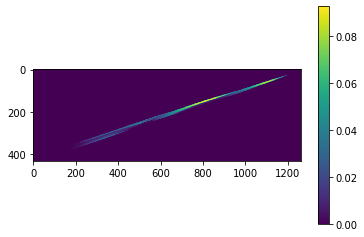

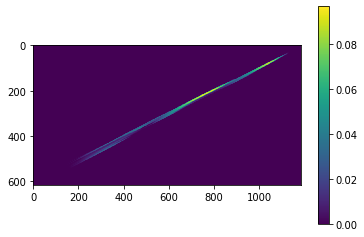

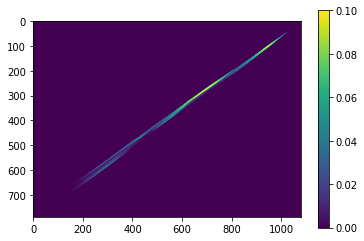

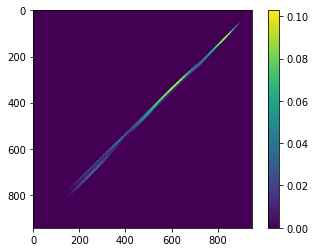

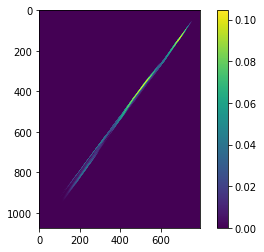

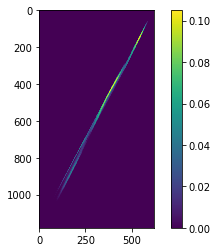

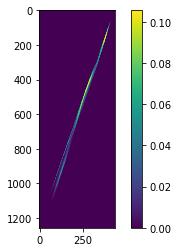

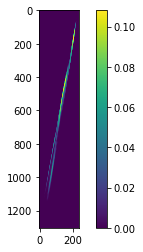

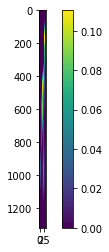

In [251]:
import pylab as py

for image1,image2 in zip(reference_measurements.images,forward_step.images):
    py.figure()
    py.imshow(image1[0])#(image1[0]-image2[0])/(image1[0]))
    py.colorbar()
    py.show()

In [250]:
print(indices)

[(9, 29, 21)]


In [239]:
M = 12
out = np.polynomial.legendre.leggauss(2*M)
mus = out[0][:len(out[0])//2]
nphis = 2*M
nphis2 = [int(0.9+nphis*np.sqrt(1.0-mu**2)) for mu in mus]

phis = np.concatenate([np.cumsum([360/nphi]*nphi) for nphi in nphis2],axis=-1)
thetas = np.concatenate([[180.0-np.rad2deg(np.arccos(mu))]*nphi for mu,nphi in zip(mus,nphis2)],axis=-1)

        
    

In [254]:
view_azimuth

array([120.        , 240.        , 360.        ,  60.        ,
       120.        , 180.        , 240.        , 300.        ,
       360.        ,  40.        ,  80.        , 120.        ,
       160.        , 200.        , 240.        , 280.        ,
       320.        , 360.        ,  30.        ,  60.        ,
        90.        , 120.        , 150.        , 180.        ,
       210.        , 240.        , 270.        , 300.        ,
       330.        , 360.        ,  24.        ,  48.        ,
        72.        ,  96.        , 120.        , 144.        ,
       168.        , 192.        , 216.        , 240.        ,
       264.        , 288.        , 312.        , 336.        ,
       360.        ,  20.        ,  40.        ,  60.        ,
        80.        , 100.        , 120.        , 140.        ,
       160.        , 180.        , 200.        , 220.        ,
       240.        , 260.        , 280.        , 300.        ,
       320.        , 340.        , 360.        ,  18.  

In [237]:
nphis2

[3,
 6,
 9,
 12,
 15,
 18,
 21,
 24,
 26,
 29,
 31,
 34,
 36,
 38,
 40,
 41,
 43,
 44,
 45,
 46,
 47,
 48,
 48,
 48]

In [240]:
len(phis)

194